# **Ściągnięcie danych z wykorzystaniem API i tweepy**

Tweet - informacje, dane:

* autor (tweet.user.screen_name)
* data publikacji (tweet.created_at)
* tekst (tweet.text)
* język wpisu (tweet.lang) - tu UWAGA! niektórzy mają wpisy po angielsku, należy je wyrzucić, jeśli mamy robić analizę językową. Trzeba zbadać też inne języki (czy były, czy po prostu język nie został rozpoznany) i zdecydować, czy wstawiamy domyślnie PL, czy usuwamy te wpisy. UND znaczy nierozpoznany język.
* liczba retweetów (tweet.retweet_count) - ile osób udostępniło wpis. UWAGA! jeśli badany tweet sam jest retweetem, ta zmienna odnosi się do oryginalnego tweeta. PYTANIE: czy jest użyteczna w analizie? Czy dla retweetów powinno tu być 0 czy usunąć retweety z analizy.
* liczba polubień (tweet.favorite_count) - ile osób polubiło wpis. UWAGA! jeśli badany tweet sam jest retweetem, tu zawsze będzie 0.
* czy tweet jest retweetem? - tej informacji nie ma bezpośrednio w żadnym obiekcie tweet. Każdy tweet będący retweetem zaczyna się od RT w tekście, ma również 0 polubień.
* czy tweet jest odpowiedzią do kogoś? (tweet.in_reply_to_screen_name) - tu będzie nazwa użytkownika, do którego odpowiedzią jest wpis (niektórzy odpowiadają sami sobie)
* czy tweet cytuje inny tweet? (tweet.is_quote_status == True) - to jeszcze inna forma udostępniania cudzej treści, ale w odróżnieniu od retweeta ma własne statystyki
* czy tweet zawiera #hashtagi? (tweet.entities['hashtags']) - pobierze się słownik zawierający tekst i pozycję hashtagów we wpisie
* czy tweet zawiera zdjęcia / filmy / linki (tweet.entities['urls']) - pobierze się słownik zawierający: dane url (url, expanded_url, display_url) oraz pozycję linków we wpisie
* czy tweet wspomina innego użytkownika (zarówno jako bezpośrednia odpowiedź, jak i w tekście wpisu) (tweet.entities['user_mentions']) - pobierze się słownik zawierający: dane wspomnianego użytkownika (screen_name, name, id) oraz położenie wspomnienia w tekście (jeśli zaczyna się od 0 - to jest to odpowiedz bezpośrednia, patrz tweet.in_reply_to_screen_name)

In [ ]:
import tweepy
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
politicians_dict = {'Name' : ['Mateusz Morawiecki', 'Krystyna Pawłowicz', 'Beata Szydło', 'Mariusz Błaszczak', 'Mariusz Kamiński', 'Antoni Macierewicz',
                              'Donald Tusk', 'Borys Budka', 'Rafał Trzaskowski', 'Tomasz Siemioniak', 'Ewa Kopacz', 'Małgorzata Kidawa-Błońska',
                              'Włodzimierz Czarzasty', 'Adrian Zandberg', 'Robert Biedroń', 'Joanna Scheuring-Wielgus', 
                              'Władysław Kosiniak-Kamysz', 'Urszula Pasławska', 'Krzysztof Hetman',
                              'Krzysztof Bosak', 'Janusz Korwin-Mikke', 'Grzegorz Braun',], 
                    'Twitter_user': ['MorawieckiM', 'KrystPawlowicz', 'BeataSzydlo', 'mblaszczak', 'Kaminski_M_', 'Macierewicz_A',
                                     'donaldtusk', 'bbudka', 'trzaskowski_', 'TomaszSiemoniak', 'EwaKopacz', 'M_K_Blonska',
                                     'wlodekczarzasty', 'ZandbergRAZEM', 'RobertBiedron', 'JoankaSW', 
                                     'KosiniakKamysz', 'Paslawska', 'Hetman_K',
                                     'krzysztofbosak', 'JkmMikke', 'GrzegorzBraun_'], 
                    'Party' : ['PiS', 'PiS', 'PiS', 'PiS', 'PiS', 'PiS',
                               'KO', 'KO', 'KO', 'KO', 'KO', 'KO',
                               'Lewica', 'Lewica', 'Lewica', 'Lewica',
                               'PSL', 'PSL', 'PSL',
                               'Konfederacja', 'Konfederacja', 'Konfederacja']}

Konto KO jest nieaktywne od 05.2020
Konto Platformy to niemal same retweety, nikt tego nie prowadzi
Platforma_org

In [ ]:
patrys_dict = {'Name' : ['Profil Partyjny',], 
               'Twitter_user': ['pisorgpl', '', '', 'nowePSL', ''], 
               'Party' : ['PiS', 'KO', 'Lewica','PSL', 'Konfederacja']}

In [ ]:
df_politicians = pd.DataFrame(politicians_dict)
df_politicians.head(22)

,Name,Twitter_user,Party
0,Mateusz Morawiecki,MorawieckiM,PiS
1,Krystyna Pawłowicz,KrystPawlowicz,PiS
2,Beata Szydło,BeataSzydlo,PiS
3,Mariusz Błaszczak,mblaszczak,PiS
4,Mariusz Kamiński,Kaminski_M_,PiS
5,Antoni Macierewicz,Macierewicz_A,PiS
6,Donald Tusk,donaldtusk,KO
7,Borys Budka,bbudka,KO
8,Rafał Trzaskowski,trzaskowski_,KO
9,Tomasz Siemioniak,TomaszSiemoniak,KO


In [ ]:
# Credentials

consumer_key = input()
consumer_secret = input()
access_token = input()
access_token_secret = input()

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
def username_tweets_to_csv(username_list,count):
  #Creating dataframe for scraped tweets data
  columns=['Author', 'Datetime', 'Tweet Id', 'Text', 'Retweet_Count', 'Favorite_Count', 'Reply_to', 
           'Language', 'Hashtags', 'URLS', 'User_mentions', 'Quote_status']
  tweets_df = pd.DataFrame(columns=columns)

  for username in username_list:
    try:      
        # Creation of query method using parameters
        tweets = tweepy.Cursor(api.user_timeline,id=username).items(count)

        # Pulling information from tweets iterable object
        tweets_list = [[tweet.user.screen_name, tweet.created_at, tweet.id, tweet.text, tweet.retweet_count, tweet.favorite_count, tweet.in_reply_to_screen_name,
                        tweet.lang, tweet.entities['hashtags'], tweet.entities['urls'], tweet.entities['user_mentions'], tweet.is_quote_status] for tweet in tweets]

        # Adding new data from tweets to dataframe
        # Add or remove columns as you remove tweet information
        tweets_df = tweets_df.append(pd.DataFrame(tweets_list,columns=columns), ignore_index=True)

        #Gdybysmy chcieli tylko autorskie wejscia :)
        #tweets_df = tweets_df[tweets_df['Retweet'].isna()]
        #tweets_df = tweets_df.drop(columns='Retweet')

    except BaseException as e:
          print('failed on_status,',str(e))
          time.sleep(3)
    
  # Converting dataframe to CSV 
  tweets_df.to_csv('polish-politicians-tweets.csv', sep=',', index = False)

In [ ]:
count = 3000
username_tweets_to_csv(df_politicians.Twitter_user, count)

# **Zbadanie danych, czyszczenie, usuwanie błędów**
4 wpisy Janusza Korwin-Mikkego zostały podzielone na dwie linijki w df.
Usunięcie błędów. Zmiana dtypów (czas na time i liczby polubień i retweetów na int)

In [ ]:
df = pd.read_csv('polish-politicians-tweets.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53140 entries, 0 to 53139
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Author          53140 non-null  object
 1   Datetime        53140 non-null  object
 2   Tweet Id        53140 non-null  int64 
 3   Text            53136 non-null  object
 4   Retweet_Count   53136 non-null  object
 5   Favorite_Count  53136 non-null  object
 6   Reply_to        7801 non-null   object
 7   Language        53136 non-null  object
 8   Hashtags        53136 non-null  object
 9   URLS            53132 non-null  object
 10  User_mentions   53132 non-null  object
 11  Quote_status    53132 non-null  object
dtypes: int64(1), object(11)
memory usage: 4.9+ MB


In [ ]:
df.head()

,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Reply_to,Language,Hashtags,URLS,User_mentions,Quote_status
0,MorawieckiM,2021-09-17 19:35:45,1438949818102161409,RT @PremierRP: Bądź na bieżąco z działaniami n...,80,0,NaN,pl,[],"[{'url': 'https://t.co/9v9c08SZsF', 'expanded_...","[{'screen_name': 'PremierRP', 'name': 'Kancela...",False
1,MorawieckiM,2021-09-17 19:35:02,1438949634907557889,Tragedia wydarzeń z 17 września 1939 roku nie ...,82,347,NaN,pl,[],"[{'url': 'https://t.co/TzJgZJOqxS', 'expanded_...",[],False
2,MorawieckiM,2021-09-14 10:03:45,1437718705245495297,RT @Czarek_Kulesza: Spotkałem się dzisiaj z Pr...,121,0,NaN,pl,[],[],"[{'screen_name': 'Czarek_Kulesza', 'name': 'Ce...",False
3,MorawieckiM,2021-09-12 19:19:03,1437133676429598721,"Polska nie miała szczęścia do historii, ale za...",208,1136,NaN,pl,[],"[{'url': 'https://t.co/v07QLJAG2U', 'expanded_...",[],False
4,MorawieckiM,2021-09-11 14:05:16,1436692320842354693,Chciałbym podziękować Pani Kanclerz za okres w...,92,518,NaN,pl,[],"[{'url': 'https://t.co/Y5f6L7iofq', 'expanded_...",[],False


In [ ]:
df.groupby(['Author'])['Tweet Id'].count()

Author
A ja mam bardzo wysoką liczbę… https://t.co/I4fRGuFBGA             1
BeataSzydlo                                                     2113
EwaKopacz                                                       1020
GrzegorzBraun_                                                  2921
Hetman_K                                                        3000
JkmMikke                                                        3000
JoankaSW                                                        3000
Kaminski_M_                                                       96
KosiniakKamysz                                                  3000
KrystPawlowicz                                                  1400
M_K_Blonska                                                     3000
Macierewicz_A                                                   3000
MorawieckiM                                                     1162
Paslawska                                                       3000
Po wprowadzeniu podatku do…

1. Konieczne będą zmiany typu danych: 
- Datatime na Datetime
- Retweet_Count i Favorite_Count na int
2. W czterech linijkach doszło do jakiegoś błędu:
- 4 linijki mają NaN w kolumnie Retweet_Count i Favorite_Count
- w kolumnie Author są cztery wpisy, które nie są na liście autorów

Być może coś się przesunęło.

In [ ]:
error_list = df.index[df['Author'].isin(df_politicians.Twitter_user) == False].tolist()
error_list

[47747, 47781, 48097, 48188]

In [ ]:
df.iloc[[47745, 47746, 47747, 47748]]

,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Reply_to,Language,Hashtags,URLS,User_mentions,Quote_status
47745,JkmMikke,2021-05-29 12:30:00,1398617620220366848,Czy wolisz pracować 2x więcej i zarabiać 4x wi...,27,329,NaN,pl,[],"[{'url': 'https://t.co/7U08wtonKQ', 'expanded_...",[],False
47746,JkmMikke,2021-05-29 08:47:44,1398561683891752964,JE Aleksander Łukaszenka podpadł (prawie...) w...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47747,Polacy też chcieliby mieć p… https://t.co/YA5L...,12,200,NaN,pl,[],"[{'url': 'https://t.co/YA5LMJZsO5', 'expanded_...",[],False,NaN,NaN,NaN
47748,JkmMikke,2021-05-29 00:00:48,1398429077850181632,NordStream2 jest znacznie większym zagrożeniem...,6,128,NaN,pl,[],"[{'url': 'https://t.co/IajOGe0LFf', 'expanded_...",[],False


Tweety z indexow 47746, 47780, 48096, 48187 zostały rozbite na dwie linijki, stąd błędy w danych.
Usuwam te 8 linijek z df.

In [ ]:
df = df.drop([47746, 47747, 47780, 47781, 48096, 48097, 48187, 48188])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53132 entries, 0 to 53139
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Author          53132 non-null  object
 1   Datetime        53132 non-null  object
 2   Tweet Id        53132 non-null  int64 
 3   Text            53132 non-null  object
 4   Retweet_Count   53132 non-null  object
 5   Favorite_Count  53132 non-null  object
 6   Reply_to        7797 non-null   object
 7   Language        53132 non-null  object
 8   Hashtags        53132 non-null  object
 9   URLS            53132 non-null  object
 10  User_mentions   53132 non-null  object
 11  Quote_status    53132 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.3+ MB


Teraz moge pozmieniac typy danych

In [ ]:
df = df.astype({'Datetime': 'datetime64', 'Retweet_Count' : 'int', 'Favorite_Count' : 'int'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53132 entries, 0 to 53139
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Author          53132 non-null  object        
 1   Datetime        53132 non-null  datetime64[ns]
 2   Tweet Id        53132 non-null  int64         
 3   Text            53132 non-null  object        
 4   Retweet_Count   53132 non-null  int64         
 5   Favorite_Count  53132 non-null  int64         
 6   Reply_to        7797 non-null   object        
 7   Language        53132 non-null  object        
 8   Hashtags        53132 non-null  object        
 9   URLS            53132 non-null  object        
 10  User_mentions   53132 non-null  object        
 11  Quote_status    53132 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 5.3+ MB


In [ ]:
df.groupby(['Author'])['Tweet Id'].count()

Author
BeataSzydlo        2113
EwaKopacz          1020
GrzegorzBraun_     2921
Hetman_K           3000
JkmMikke           2996
JoankaSW           3000
Kaminski_M_          96
KosiniakKamysz     3000
KrystPawlowicz     1400
M_K_Blonska        3000
Macierewicz_A      3000
MorawieckiM        1162
Paslawska          3000
RobertBiedron      1640
TomaszSiemoniak    3000
ZandbergRAZEM      3000
bbudka             3000
donaldtusk          784
krzysztofbosak     3000
mblaszczak         3000
trzaskowski_       3000
wlodekczarzasty    3000
Name: Tweet Id, dtype: int64

# Język tweetów
Oprócz tweetów po polsku są też wpisy w innych językach.
Niektórzy autorzy piszą również po angielsku.
Pozostałe języki i nierozpoznany język to albo wpisy w innych językach albo wpisy z samymi hastagami (bez tekstu) albo wpisy tak krótkie / nieortograficzne (odpowiedzi K. Pawłowicz), że język nie został rozpoznany.

In [ ]:
df.groupby(['Language'])['Tweet Id'].count()
# und to jezyk nierozpoznany

Language
ca         2
cs        21
cy         2
da         5
de         8
en      1003
es        47
et         5
eu         5
fi         1
fr         8
hi         1
ht         2
hu         7
in        32
it        31
ja         1
lt         3
lv         5
nl         4
no         1
pl     50473
pt        12
ro         5
ru        10
sl         5
sv         3
tl         7
tr         5
uk        12
und     1406
Name: Tweet Id, dtype: int64

In [ ]:
#Morawiecki i Szydło często piszą po angielsku, sprawdzam, co z innymi językami i z tweetami z nierozpoznanym językiem
other_languages = df[df['Language'].isin(['pl', 'en', 'und']) == False]
for tweet in other_languages['Text']:
  print(tweet)

З великим жалем вивчив нoвину про трагічну аварію українського автобусу на автошлягу A4 під Ярославом. Виражаю щире… https://t.co/Bg4gxYhYIK
安倍首相、日本-ポーランドの戦略的関係の発展、そしてV4＋日本関係を深めるために多大なるご尽力を頂いたことに感謝致します。
ご多幸とご健康をお祈り申し上げます。 https://t.co/T5O6BISfHT
Заклікаем улады РБ вызваліць усіх прадстаўнікоў апазіцыі, якія незаконна затрыманыя і выкліканыя на допыты. Нормай… https://t.co/xiq8ItgNo0
Je suis profondément touché par la mort de 13 militaires  français décédés lors d’une mission au Mali. Je salue leu… https://t.co/S53K8kGaYJ
U příležitosti českého národního svátku 17 listopadu přeju všem Čechům a celé české vládě dalších úspěchů v rozvoji… https://t.co/qcu7WBJlC4
Aitäh, Jüri! Aitäh, Eesti! Vendlus ja liit Poola ja Eesti rahvaste vahel jääb püsima! Elagu Poola, elagu Eesti – me… https://t.co/sUFyZV9nQJ
@KrtkToja A bo co ?
@janek_W1 Cudo.
@janek_W1 @MariaL19111 @durczokk Pan go ma.
León !
León - kat Ruskich !
León,León,León !
León,Kurek !
Kubiak !!!
@HMaegerle Omijam
@vespa_mndarinia Ten min

Większość to rzeczywiście teksty w innych językach plus zaczepki Krystyny Pawłowicz, które się tak sklasyfikowały. Do wyrzucenia.

In [ ]:
no_language = df[df['Language'] == 'und']
for tweet in no_language['Text']:
  print(tweet)

#RzeszówMaMoc 🇵🇱 https://t.co/z8apySQIjV
#SzczepimySię https://t.co/pFRiHxXxSR
#SzczepimySię https://t.co/WLEq8JiO4u
#LiczySięPolska 🇵🇱 https://t.co/Tha6NVkpcp
#LiczySięPolska 🇵🇱 https://t.co/zZqKdvzryL
#LiczySięPolska 🇵🇱 https://t.co/jKrMefr0YL
#SzczepimySię https://t.co/X4vbNPkQ0a
🇵🇱 https://t.co/HAm3jYQDw0
K 30. výročiu #NežnáRevolúcia želám všetko najlepšie a veľa úspechov premiérovi @PellegriniP_ a celému slovenskému… https://t.co/JyTiaydd65
@SamPereira_ @drSucha1 ‼️‼️‼️‼️‼️
@vespa_mndarinia A co..!
@jbstepien Bajka.
@vespa_mndarinia .
@GadaStan TAK !
@vespa_mndarinia 😇
@vespa_mndarinia Co ?
@figakobi2 Jak ?
@FSkrzeszewski Tzn .?
.@Amb_Niemiec
@LinkowskiTomek Nie !!!
RT @JSaryuszWolski: 168
@Joanna_Czarna @krisp57 Fe..
RT @SamnajT: 😂 https://t.co/0Ul8v1MVXh
@Eric00001989 Nooo,..
@TPacze @sikorskiradek Nie
@pawcio65 Nie.
@EwaBaumgardt Nie
@kakunka_pl Samo dobro ..
⁉️⁉️⁉️ !!!!!!!!!!!!!!!!!!!!‼️‼️‼️‼️‼️⁉️⁉️ https://t.co/Yo8l1qTsCi
https://t.co/AOKcT0CbOA
@Lukasz280382 @Elka68354587 T

Większość to tweety w zasadzie bez tekstu, zawierające tylko hashtagi, @odwołania i linki plus jednowyrazowe albo niegramatyczne odpowiedzi Krystyny Pawłowicz. 

Zobaczmy, kto ma tego najwięcej.

In [ ]:
df.groupby(['Author', 'Language'])['Tweet Id'].count()

Author           Language
BeataSzydlo      cs            1
                 cy            1
                 en           66
                 hi            1
                 hu            1
                            ... 
wlodekczarzasty  pt            3
                 sl            1
                 sv            1
                 tl            1
                 und         189
Name: Tweet Id, Length: 213, dtype: int64

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


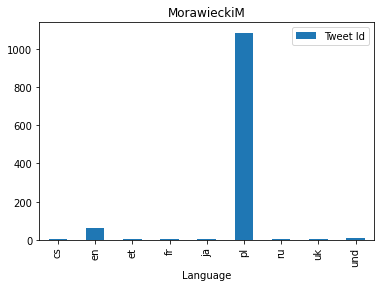

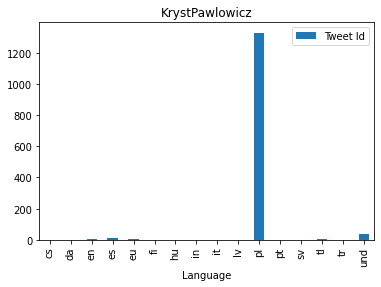

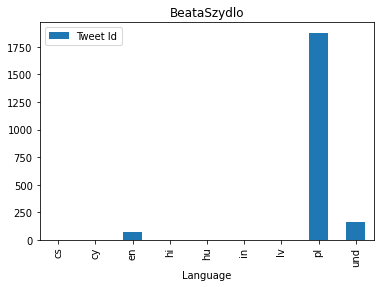

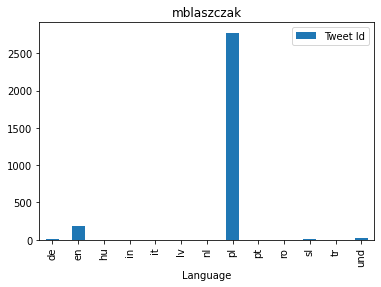

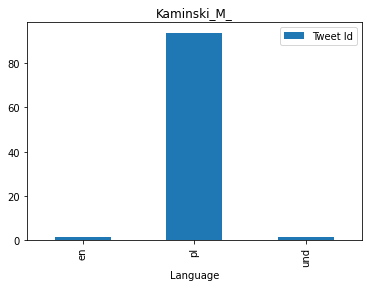

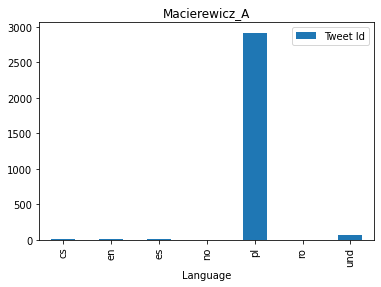

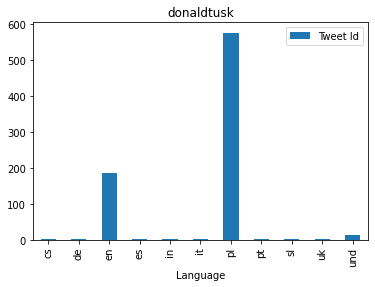

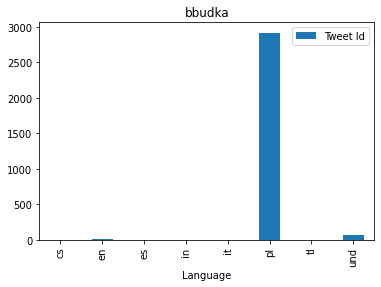

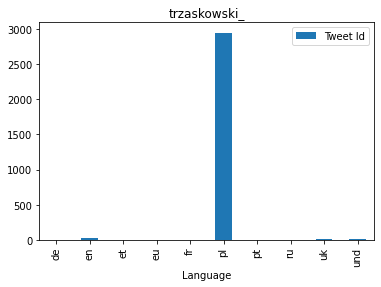

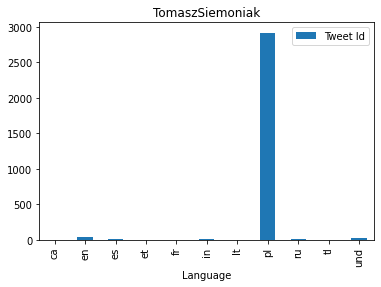

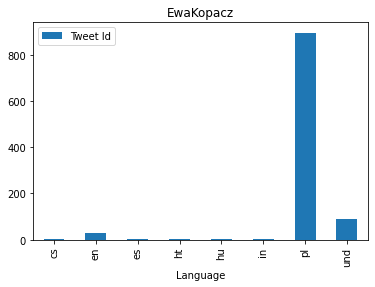

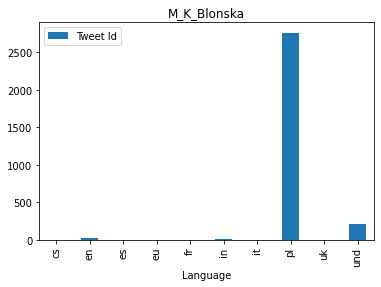

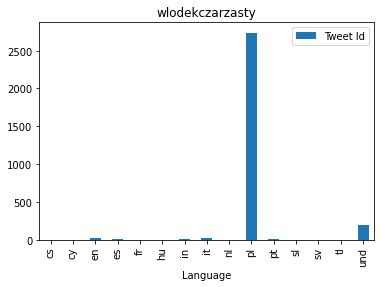

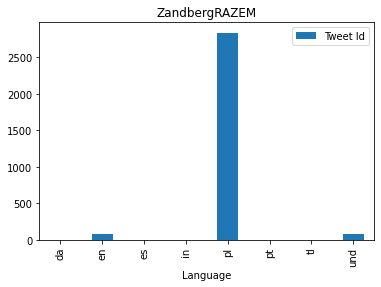

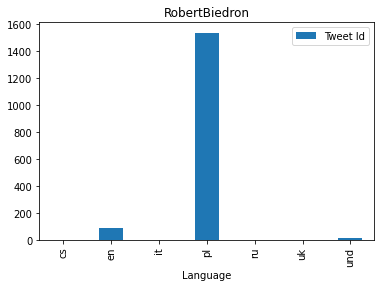

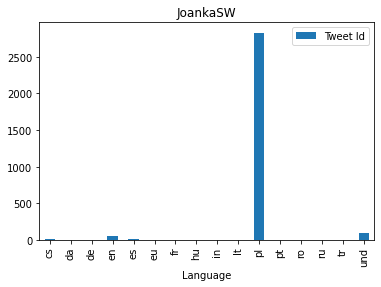

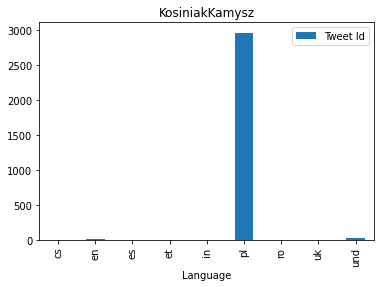

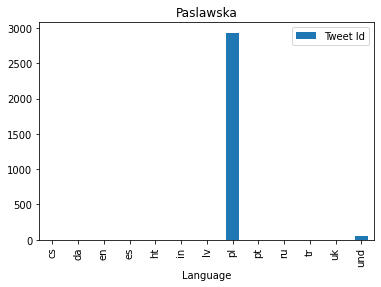

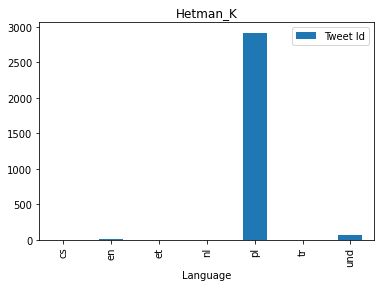

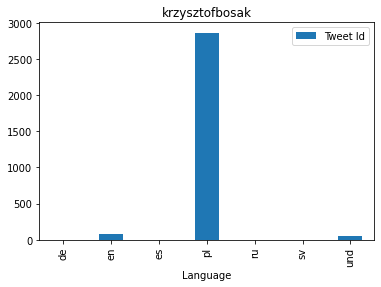

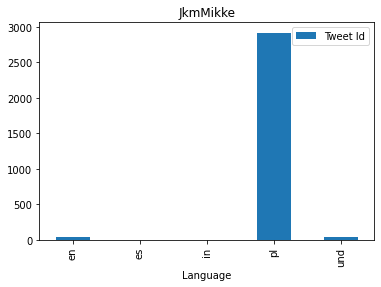

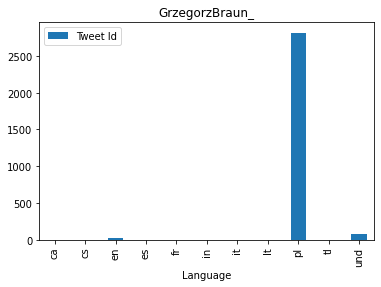

In [ ]:
for author in df_politicians.Twitter_user:
  author_df = pd.DataFrame(df[df['Author'] == author].groupby(['Language'])['Tweet Id'].count())
  author_df.plot.bar()
  plt.title(author)

# Bardzo wstępny preprocessing
Zmiany w df:
Kategoryzacja danych:
1. kolumna Language: zamiana na **Lang_PL** >>> True, jeśli tekst jest po polsku, False, jeśli jest w innym języku (żebyśmy nie analizowali tekstów w innych językach)
2. kolumna Reply_to: zamiana na **Is_reply** >>> True, jeśli jest odpowiedzią, False jeśli jest NaN w tej kolumnie
3. dodatkowa kolumna: **Is_retweet**,  jeśli tekst tweeta zaczyna się od RT
4. kolumna Hashtags na **Has_hastags**: True, jeśli występują hastagi, False, jeśli jest pusta lista [] w tej kolumnie
5. kolumna URLS na **Has_url**: True, jeśli występują linki i media, False, jeśli jest pusta lista [] w tej kolumnie
6. kolumna User_mentions na **Has_user_mentions**: True, jeśli wspomniani są inni użytkownicy, False, jeśli jest pusta lista [] w tej kolumnie
Zmiana autorów - z user_name na imię i nazwisko
Dodanie kolumny Patry - informacja o partii

In [ ]:
df['Lang_PL'] = np.where(df['Language'] == 'pl', True, False)
df['Is_reply'] = np.where(df['Reply_to'].isna(), False, True)
df['Is_retweet'] = np.where(df['Text'].str.startswith('RT'), True, False)
df['Has_hastags'] = np.where(df['Hashtags']!= '[]', True, False)
df['Has_url'] = np.where(df['URLS']!= '[]', True, False)
df['Has_user_mentions'] = np.where(df['User_mentions']!= '[]', True, False)
df


,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Reply_to,Language,Hashtags,URLS,User_mentions,Quote_status,Lang_PL,Is_reply,Is_retweet,Has_hastags,Has_url,Has_user_mentions
0,MorawieckiM,2021-09-17 19:35:45,1438949818102161409,RT @PremierRP: Bądź na bieżąco z działaniami n...,80,0,NaN,pl,[],"[{'url': 'https://t.co/9v9c08SZsF', 'expanded_...","[{'screen_name': 'PremierRP', 'name': 'Kancela...",False,True,False,True,False,True,True
1,MorawieckiM,2021-09-17 19:35:02,1438949634907557889,Tragedia wydarzeń z 17 września 1939 roku nie ...,82,347,NaN,pl,[],"[{'url': 'https://t.co/TzJgZJOqxS', 'expanded_...",[],False,True,False,False,False,True,False
2,MorawieckiM,2021-09-14 10:03:45,1437718705245495297,RT @Czarek_Kulesza: Spotkałem się dzisiaj z Pr...,121,0,NaN,pl,[],[],"[{'screen_name': 'Czarek_Kulesza', 'name': 'Ce...",False,True,False,True,False,False,True
3,MorawieckiM,2021-09-12 19:19:03,1437133676429598721,"Polska nie miała szczęścia do historii, ale za...",208,1136,NaN,pl,[],"[{'url': 'https://t.co/v07QLJAG2U', 'expanded_...",[],False,True,False,False,False,True,False
4,MorawieckiM,2021-09-11 14:05:16,1436692320842354693,Chciałbym podziękować Pani Kanclerz za okres w...,92,518,NaN,pl,[],"[{'url': 'https://t.co/Y5f6L7iofq', 'expanded_...",[],False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53135,GrzegorzBraun_,2019-11-10 11:46:17,1193495086140678146,"Szczęść Boże, zapraszam serdecznie do oglądani...",61,272,NaN,pl,"[{'text': 'Minela20', 'indices': [57, 66]}]",[],"[{'screen_name': 'tvp_info', 'name': 'tvp.info...",False,True,False,False,True,False,True
53136,GrzegorzBraun_,2019-11-09 16:52:23,1193209730010927105,"W dniu inauguracji obrad Sejmu IX kadencji, 12...",97,649,NaN,pl,[],"[{'url': 'https://t.co/qgioVMnnWw', 'expanded_...",[],False,True,False,False,False,True,False
53137,GrzegorzBraun_,2019-11-08 22:02:53,1192925482351779846,Najwyraźniej w Archidiecezji Warszawskiej lewo...,26,90,NaN,pl,[],"[{'url': 'https://t.co/sTkdgtkEB2', 'expanded_...",[],True,True,False,False,False,True,False
53138,GrzegorzBraun_,2019-11-05 08:51:06,1191639060546228226,Panie premierze @MorawieckiM czy podziela Pan ...,135,563,NaN,pl,[],[],"[{'screen_name': 'MorawieckiM', 'name': 'Mateu...",False,True,False,False,False,False,True


Przy retweetach usuwam zmienną liczba retweetów - wstawiam zero, bo te dane dot. tweeta oryginalnego, nawet jak ktoś odpowie, to odpowie nadawcy oryginalnemu

In [ ]:
df.loc[df.Is_retweet == True, 'Retweet_Count'] = 0
df

,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Reply_to,Language,Hashtags,URLS,User_mentions,Quote_status,Lang_PL,Is_reply,Is_retweet,Has_hastags,Has_url,Has_user_mentions
0,MorawieckiM,2021-09-17 19:35:45,1438949818102161409,RT @PremierRP: Bądź na bieżąco z działaniami n...,0,0,NaN,pl,[],"[{'url': 'https://t.co/9v9c08SZsF', 'expanded_...","[{'screen_name': 'PremierRP', 'name': 'Kancela...",False,True,False,True,False,True,True
1,MorawieckiM,2021-09-17 19:35:02,1438949634907557889,Tragedia wydarzeń z 17 września 1939 roku nie ...,82,347,NaN,pl,[],"[{'url': 'https://t.co/TzJgZJOqxS', 'expanded_...",[],False,True,False,False,False,True,False
2,MorawieckiM,2021-09-14 10:03:45,1437718705245495297,RT @Czarek_Kulesza: Spotkałem się dzisiaj z Pr...,0,0,NaN,pl,[],[],"[{'screen_name': 'Czarek_Kulesza', 'name': 'Ce...",False,True,False,True,False,False,True
3,MorawieckiM,2021-09-12 19:19:03,1437133676429598721,"Polska nie miała szczęścia do historii, ale za...",208,1136,NaN,pl,[],"[{'url': 'https://t.co/v07QLJAG2U', 'expanded_...",[],False,True,False,False,False,True,False
4,MorawieckiM,2021-09-11 14:05:16,1436692320842354693,Chciałbym podziękować Pani Kanclerz za okres w...,92,518,NaN,pl,[],"[{'url': 'https://t.co/Y5f6L7iofq', 'expanded_...",[],False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53135,GrzegorzBraun_,2019-11-10 11:46:17,1193495086140678146,"Szczęść Boże, zapraszam serdecznie do oglądani...",61,272,NaN,pl,"[{'text': 'Minela20', 'indices': [57, 66]}]",[],"[{'screen_name': 'tvp_info', 'name': 'tvp.info...",False,True,False,False,True,False,True
53136,GrzegorzBraun_,2019-11-09 16:52:23,1193209730010927105,"W dniu inauguracji obrad Sejmu IX kadencji, 12...",97,649,NaN,pl,[],"[{'url': 'https://t.co/qgioVMnnWw', 'expanded_...",[],False,True,False,False,False,True,False
53137,GrzegorzBraun_,2019-11-08 22:02:53,1192925482351779846,Najwyraźniej w Archidiecezji Warszawskiej lewo...,26,90,NaN,pl,[],"[{'url': 'https://t.co/sTkdgtkEB2', 'expanded_...",[],True,True,False,False,False,True,False
53138,GrzegorzBraun_,2019-11-05 08:51:06,1191639060546228226,Panie premierze @MorawieckiM czy podziela Pan ...,135,563,NaN,pl,[],[],"[{'screen_name': 'MorawieckiM', 'name': 'Mateu...",False,True,False,False,False,False,True


In [ ]:
df_politicians

,Name,Twitter_user,Party
0,Mateusz Morawiecki,MorawieckiM,PiS
1,Krystyna Pawłowicz,KrystPawlowicz,PiS
2,Beata Szydło,BeataSzydlo,PiS
3,Mariusz Błaszczak,mblaszczak,PiS
4,Mariusz Kamiński,Kaminski_M_,PiS
5,Antoni Macierewicz,Macierewicz_A,PiS
6,Donald Tusk,donaldtusk,KO
7,Borys Budka,bbudka,KO
8,Rafał Trzaskowski,trzaskowski_,KO
9,Tomasz Siemioniak,TomaszSiemoniak,KO


In [ ]:
df_clean = df.drop(['Language', 'Hashtags', 'URLS', 'User_mentions', 'Reply_to'], axis=1)


In [ ]:
df_clean = df_clean.merge(df_politicians, left_on='Author', right_on='Twitter_user')
df_clean = df_clean.drop('Twitter_user', axis=1)
df_clean

,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Quote_status,Lang_PL,Is_reply,Is_retweet,Has_hastags,Has_url,Has_user_mentions,Name,Party
0,MorawieckiM,2021-09-17 19:35:45,1438949818102161409,RT @PremierRP: Bądź na bieżąco z działaniami n...,0,0,False,True,False,True,False,True,True,Mateusz Morawiecki,PiS
1,MorawieckiM,2021-09-17 19:35:02,1438949634907557889,Tragedia wydarzeń z 17 września 1939 roku nie ...,82,347,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS
2,MorawieckiM,2021-09-14 10:03:45,1437718705245495297,RT @Czarek_Kulesza: Spotkałem się dzisiaj z Pr...,0,0,False,True,False,True,False,False,True,Mateusz Morawiecki,PiS
3,MorawieckiM,2021-09-12 19:19:03,1437133676429598721,"Polska nie miała szczęścia do historii, ale za...",208,1136,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS
4,MorawieckiM,2021-09-11 14:05:16,1436692320842354693,Chciałbym podziękować Pani Kanclerz za okres w...,92,518,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53127,GrzegorzBraun_,2019-11-10 11:46:17,1193495086140678146,"Szczęść Boże, zapraszam serdecznie do oglądani...",61,272,False,True,False,False,True,False,True,Grzegorz Braun,Konfederacja
53128,GrzegorzBraun_,2019-11-09 16:52:23,1193209730010927105,"W dniu inauguracji obrad Sejmu IX kadencji, 12...",97,649,False,True,False,False,False,True,False,Grzegorz Braun,Konfederacja
53129,GrzegorzBraun_,2019-11-08 22:02:53,1192925482351779846,Najwyraźniej w Archidiecezji Warszawskiej lewo...,26,90,True,True,False,False,False,True,False,Grzegorz Braun,Konfederacja
53130,GrzegorzBraun_,2019-11-05 08:51:06,1191639060546228226,Panie premierze @MorawieckiM czy podziela Pan ...,135,563,False,True,False,False,False,False,True,Grzegorz Braun,Konfederacja


Ustaliliśmy, że bierzemy dane od 01-01-2020

In [ ]:
df_clean = df_clean[df_clean['Datetime'] > pd.to_datetime('2020-01-01')]

In [ ]:
df_clean['date'] = pd.to_datetime(df_clean['Datetime']).dt.date
df_clean['time'] = pd.to_datetime(df_clean['Datetime']).dt.time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_clean

,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Quote_status,Lang_PL,Is_reply,Is_retweet,Has_hastags,Has_url,Has_user_mentions,Name,Party,date,time
0,MorawieckiM,2021-09-17 19:35:45,1438949818102161409,RT @PremierRP: Bądź na bieżąco z działaniami n...,0,0,False,True,False,True,False,True,True,Mateusz Morawiecki,PiS,2021-09-17,19:35:45
1,MorawieckiM,2021-09-17 19:35:02,1438949634907557889,Tragedia wydarzeń z 17 września 1939 roku nie ...,82,347,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS,2021-09-17,19:35:02
2,MorawieckiM,2021-09-14 10:03:45,1437718705245495297,RT @Czarek_Kulesza: Spotkałem się dzisiaj z Pr...,0,0,False,True,False,True,False,False,True,Mateusz Morawiecki,PiS,2021-09-14,10:03:45
3,MorawieckiM,2021-09-12 19:19:03,1437133676429598721,"Polska nie miała szczęścia do historii, ale za...",208,1136,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS,2021-09-12,19:19:03
4,MorawieckiM,2021-09-11 14:05:16,1436692320842354693,Chciałbym podziękować Pani Kanclerz za okres w...,92,518,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS,2021-09-11,14:05:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53106,GrzegorzBraun_,2020-01-16 16:12:29,1217842066283286531,10 rocznica zamachu warszawsko-smoleńskiego za...,257,824,False,True,False,False,False,True,True,Grzegorz Braun,Konfederacja,2020-01-16,16:12:29
53107,GrzegorzBraun_,2020-01-09 19:38:15,1215357134608781315,Nota bene: za pare godzin upływa termin rejest...,28,175,False,True,False,False,False,True,False,Grzegorz Braun,Konfederacja,2020-01-09,19:38:15
53108,GrzegorzBraun_,2020-01-09 19:33:27,1215355925231435777,Przed chwilą w TV Republika (program W Punkt r...,18,170,False,True,False,False,False,True,False,Grzegorz Braun,Konfederacja,2020-01-09,19:33:27
53109,GrzegorzBraun_,2020-01-08 19:44:53,1214996416025780226,Za kwadrans w programie Twój Wybór w TVP Info ...,22,208,False,True,False,False,False,False,False,Grzegorz Braun,Konfederacja,2020-01-08,19:44:53


In [ ]:
df_clean.to_csv('tweets.csv')

In [ ]:
df_clean[df_clean['Is_retweet'] == False].groupby('Author')['Tweet Id'].count()

Author
BeataSzydlo         299
EwaKopacz           399
GrzegorzBraun_     1234
Hetman_K            151
JkmMikke           2384
JoankaSW           1341
Kaminski_M_          37
KosiniakKamysz     2256
KrystPawlowicz     1349
M_K_Blonska         994
Macierewicz_A       349
MorawieckiM         430
Paslawska          1045
RobertBiedron       671
TomaszSiemoniak     743
ZandbergRAZEM      1471
bbudka             1031
donaldtusk          178
krzysztofbosak     1382
mblaszczak          757
trzaskowski_       2125
wlodekczarzasty    2629
Name: Tweet Id, dtype: int64

Wczytuje dane od Emila

In [ ]:
df_emil = pd.read_csv('merged.csv', sep=';', error_bad_lines=False)
df_emil

b'Skipping line 578: expected 6 fields, saw 7\nSkipping line 1516: expected 6 fields, saw 7\nSkipping line 1524: expected 6 fields, saw 7\nSkipping line 1527: expected 6 fields, saw 7\nSkipping line 1533: expected 6 fields, saw 7\nSkipping line 1543: expected 6 fields, saw 7\nSkipping line 1549: expected 6 fields, saw 7\nSkipping line 1582: expected 6 fields, saw 7\nSkipping line 1583: expected 6 fields, saw 7\nSkipping line 1602: expected 6 fields, saw 7\nSkipping line 1606: expected 6 fields, saw 7\nSkipping line 1616: expected 6 fields, saw 7\nSkipping line 1638: expected 6 fields, saw 7\nSkipping line 1639: expected 6 fields, saw 7\nSkipping line 1648: expected 6 fields, saw 7\nSkipping line 1649: expected 6 fields, saw 7\nSkipping line 1664: expected 6 fields, saw 7\nSkipping line 1669: expected 6 fields, saw 7\nSkipping line 1670: expected 6 fields, saw 7\nSkipping line 1673: expected 6 fields, saw 7\nSkipping line 1680: expected 6 fields, saw 7\nSkipping line 1705: expected 6 fi

,polit_party,username,datetime,tweet,comments,likes
0,KO,Borys Budka,2021-09-14T17:38:00.000Z,"Dziękujemy, że jesteście z nami",383,"1,2 tys."
1,KO,Borys Budka,2021-09-13T07:01:30.000Z,Obsadzili #neoKRS swoimi ludźmi. Potem do Izby...,385,581
2,KO,Borys Budka,2021-09-11T12:47:01.000Z,.@adam_korol nowym prezesem @PLwioslaPZTW Serd...,7,51
3,KO,Borys Budka,2021-09-10T12:24:40.000Z,"Ani się człowiek obejrzał, a oni już wszystko ...",268,644
4,KO,Borys Budka,2021-09-08T18:29:45.000Z,"Od 6 lat rządzący zohydzają Unię Europejską, p...",490,"1,7 tys."
...,...,...,...,...,...,...
9120,PSL,Urszula Pasławska,2020-07-24T19:51:57.000Z,"Proszę więc o przykłady przepisów, które władz...",1,NaN
9121,PSL,Urszula Pasławska,2020-07-24T19:18:00.000Z,Nawet w opozycji ważna jest odpowiedzialność z...,1,NaN
9122,PSL,Urszula Pasławska,2020-07-24T19:00:32.000Z,Czy wymóg praworządności jest aż tak trudny do...,1,NaN
9123,PSL,Urszula Pasławska,2020-07-24T18:33:29.000Z,Media prywatne z definicji powinny być niezale...,1,1


In [ ]:
df_emil['Date'] = df_emil['datetime'].str[:10]
df_emil['Time'] = df_emil['datetime'].str[11:19]
df_emil['Datetime'] = df_emil['Date'] + ' ' + df_emil['Time']
df_emil = df_emil.drop(['Date', 'Time'], axis=1)

In [ ]:
df_emil = df_emil[df_emil['Datetime'] > '2020-01-01']

In [ ]:
df_emil.groupby('username')['tweet'].count()

username
Adrian Zandberg                  484
Antoni Macierewicz               222
Beata Szydło                     171
Borys Budka                      498
Donald Tusk                      102
Ewa Kopacz                       231
Grzegorz Braun                   472
J. Scheuring-Wielgus             482
Janusz Korwin-Mikke              455
Krystyna Pawłowicz               499
Krzysztof Bosak                  485
Krzysztof Hetman                  77
M. Kidawa-Błońska                500
Mariusz Błaszczak                392
Mariusz Kamiński                  26
Mateusz Morawiecki               254
Rafał Trzaskowski                498
Robert Biedroń                   485
Tomasz Siemoniak                 499
Urszula Pasławska                494
Władysław Kosiniak-Kamysz        497
WłodzimierzCzarzasty  #Lewica    464
Name: tweet, dtype: int64

Merguje dane z API i od Emila po datetime

In [ ]:
df_test = pd.read_csv('tweets.csv', index_col='Unnamed: 0')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43149 entries, 0 to 53110
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Author             43149 non-null  object
 1   Datetime           43149 non-null  object
 2   Tweet Id           43149 non-null  int64 
 3   Text               43149 non-null  object
 4   Retweet_Count      43149 non-null  int64 
 5   Favorite_Count     43149 non-null  int64 
 6   Quote_status       43149 non-null  bool  
 7   Lang_PL            43149 non-null  bool  
 8   Is_reply           43149 non-null  bool  
 9   Is_retweet         43149 non-null  bool  
 10  Has_hastags        43149 non-null  bool  
 11  Has_url            43149 non-null  bool  
 12  Has_user_mentions  43149 non-null  bool  
 13  Name               43149 non-null  object
 14  Party              43149 non-null  object
 15  date               43149 non-null  object
 16  time               43149 non-null  objec

In [ ]:
df_all = df_test.merge(df_emil, how='inner', left_on='Datetime', right_on='Datetime', right_index=False )


In [ ]:
df_all

,Author,Datetime,Tweet Id,Text,Retweet_Count,Favorite_Count,Quote_status,Lang_PL,Is_reply,Is_retweet,Has_hastags,Has_url,Has_user_mentions,Name,Party,date,time,polit_party,username,datetime,tweet,comments,likes
0,MorawieckiM,2021-09-11 14:05:16,1436692320842354693,Chciałbym podziękować Pani Kanclerz za okres w...,92,518,False,True,False,False,False,True,False,Mateusz Morawiecki,PiS,2021-09-11,14:05:16,PIS,Mateusz Morawiecki,2021-09-11T14:05:16.000Z,Chciałbym podziękować Pani Kanclerz za okres w...,309,508
1,MorawieckiM,2021-09-11 09:27:15,1436622357829988353,9/11 was not just an attack on the U.S. The WT...,96,378,False,False,False,False,False,True,False,Mateusz Morawiecki,PiS,2021-09-11,09:27:15,PIS,Mateusz Morawiecki,2021-09-11T09:27:15.000Z,9/11 was not just an attack on the U.S. The WT...,70,376
2,MorawieckiM,2021-09-08 21:14:49,1435713257982119941,"Brawo! 🇵🇱🇵🇱🇵🇱 Charakter, jaki pokazaliście w t...",179,2145,False,True,False,False,False,False,False,Mateusz Morawiecki,PiS,2021-09-08,21:14:49,PIS,Mateusz Morawiecki,2021-09-08T21:14:49.000Z,"Brawo! Charakter, jaki pokazaliście w tym mecz...",374,"2,1 tys."
3,MorawieckiM,2021-09-01 20:05:57,1433159210242646023,"Today I visited picturesque Bled, which now be...",100,352,False,False,False,False,False,True,False,Mateusz Morawiecki,PiS,2021-09-01,20:05:57,PIS,Mateusz Morawiecki,2021-09-01T20:05:57.000Z,"Today I visited picturesque Bled, which now be...",144,352
4,MorawieckiM,2021-09-01 11:25:56,1433028346233905157,"Oddali życie za Polskę, ale żyją na wieki w na...",122,600,False,True,False,False,True,True,False,Mateusz Morawiecki,PiS,2021-09-01,11:25:56,PIS,Mateusz Morawiecki,2021-09-01T11:25:56.000Z,"Oddali życie za Polskę, ale żyją na wieki w na...",83,595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7609,GrzegorzBraun_,2020-04-03 19:36:50,1246159744789815299,Korekta: godzinę rozpoczęcia posiedzenia zmien...,27,144,True,True,False,False,False,True,False,Grzegorz Braun,Konfederacja,2020-04-03,19:36:50,KON,Grzegorz Braun,2020-04-03T19:36:50.000Z,Korekta: godzinę rozpoczęcia posiedzenia zmien...,2,144
7610,GrzegorzBraun_,2020-04-03 12:56:06,1246058897703567362,Min. Prawdy w działaniu - na stronce ⁦⁦@Kancel...,25,107,False,True,False,False,False,True,True,Grzegorz Braun,Konfederacja,2020-04-03,12:56:06,KON,Grzegorz Braun,2020-04-03T12:56:06.000Z,Min. Prawdy w działaniu - na stronce ⁦⁦@Kancel...,3,107
7611,GrzegorzBraun_,2020-04-03 11:35:19,1246038568306270210,Na marginesie: Biuro Spraw M/nar. Kanc. Sejmu ...,44,160,False,True,False,False,False,True,False,Grzegorz Braun,Konfederacja,2020-04-03,11:35:19,KON,Grzegorz Braun,2020-04-03T11:35:19.000Z,Na marginesie: Biuro Spraw M/nar. Kanc. Sejmu ...,22,160
7612,GrzegorzBraun_,2020-04-03 11:03:47,1246030631194279938,Nota bene: J. Gowin zaczyna właśnie SWOJĄ kamp...,79,601,False,True,False,False,False,False,False,Grzegorz Braun,Konfederacja,2020-04-03,11:03:47,KON,Grzegorz Braun,2020-04-03T11:03:47.000Z,Nota bene: J. Gowin zaczyna właśnie SWOJĄ kamp...,116,602


In [ ]:
df_all.iloc[122]

Author                              MorawieckiM
Datetime                    2020-11-11 12:37:23
Tweet Id                    1326504294280024064
Text                 🇵🇱 https://t.co/HAm3jYQDw0
Retweet_Count                                97
Favorite_Count                              917
Quote_status                              False
Lang_PL                                   False
Is_reply                                  False
Is_retweet                                False
Has_hastags                               False
Has_url                                   False
Has_user_mentions                         False
Name                         Mateusz Morawiecki
Party                                       PiS
date                                 2020-11-11
time                                   12:37:23
polit_party                                 PIS
username                     Mateusz Morawiecki
datetime               2020-11-11T12:37:23.000Z
tweet                                   

In [ ]:
df_all.to_csv('tweets_API_EMIL_inner.csv')

In [ ]:
df_all.groupby('Lang_PL')['Tweet Id'].count()

Lang_PL
False     374
True     7240
Name: Tweet Id, dtype: int64

# Wizualizacje

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('final_data.csv', index_col='Unnamed: 0', engine='python')
data['Date'] = pd.to_datetime(data['Datetime']).dt.date
data['Time'] = pd.to_datetime(data['Datetime']).dt.time
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65954 entries, 0 to 75084
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Author             65954 non-null  object
 1   Datetime           65954 non-null  object
 2   Tweet Id           65954 non-null  int64 
 3   Text               65954 non-null  object
 4   Retweet_Count      65954 non-null  int64 
 5   Favorite_Count     65954 non-null  int64 
 6   Quote_status       65954 non-null  bool  
 7   Lang_PL            65954 non-null  bool  
 8   Is_reply           65954 non-null  bool  
 9   Is_retweet         65954 non-null  bool  
 10  Has_hastags        65954 non-null  bool  
 11  Has_url            65954 non-null  bool  
 12  Has_user_mentions  65954 non-null  bool  
 13  Name               65954 non-null  object
 14  Party              65954 non-null  object
 15  date               65954 non-null  object
 16  time               65954 non-null  objec

In [ ]:
data['year'] = pd.DatetimeIndex(data['Datetime']).year
data['month'] = pd.DatetimeIndex(data['Datetime']).month
data['hour'] = pd.DatetimeIndex(data['Datetime']).hour

In [ ]:
data.groupby('Lang_PL')['Tweet Id'].count()

Lang_PL
False     2586
True     63368
Name: Tweet Id, dtype: int64

In [ ]:
dlugosc_tweet = len(str(data['Text'][0]))

In [ ]:
dlugosc_tweet

135

In [ ]:
data.iloc[0]

Author                                                       KLubnauer
Datetime                                           2021-09-18 14:19:10
Tweet Id                                           1439232533758099456
Text                 Dobry pomysł @Platforma_org o zorganizowaniu k...
Retweet_Count                                                        5
Favorite_Count                                                     109
Quote_status                                                     False
Lang_PL                                                           True
Is_reply                                                         False
Is_retweet                                                       False
Has_hastags                                                      False
Has_url                                                           True
Has_user_mentions                                                 True
Name                                                Katarzyna Lubnauer
Party 

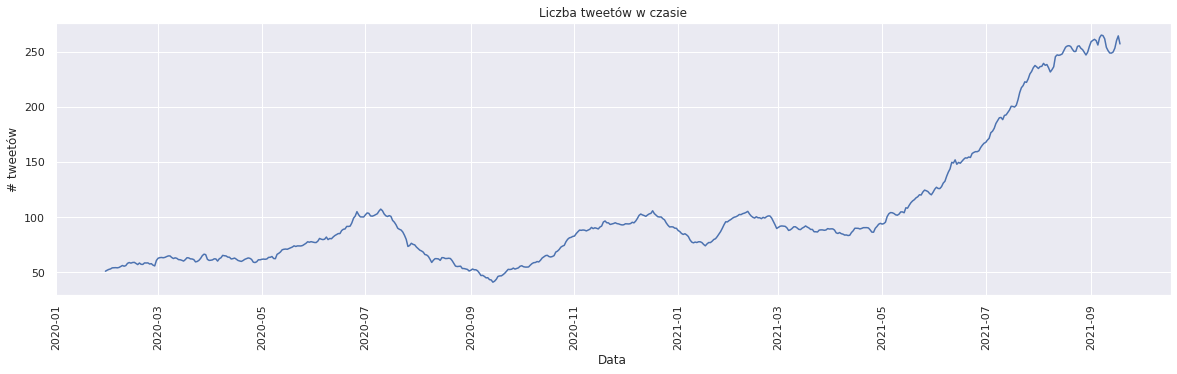

In [ ]:
tweets_in_time = data.groupby('date')[['Tweet Id']].count()
tweets_in_time['SMA_30'] = tweets_in_time['Tweet Id'].rolling(window=30).mean()

plt.figure(figsize=(20,5))
plt.plot(tweets_in_time['SMA_30'])
plt.xlabel('Data')
plt.xticks(rotation=90)
plt.ylabel('# tweetów')
plt.title('Liczba tweetów w czasie')
plt.show()

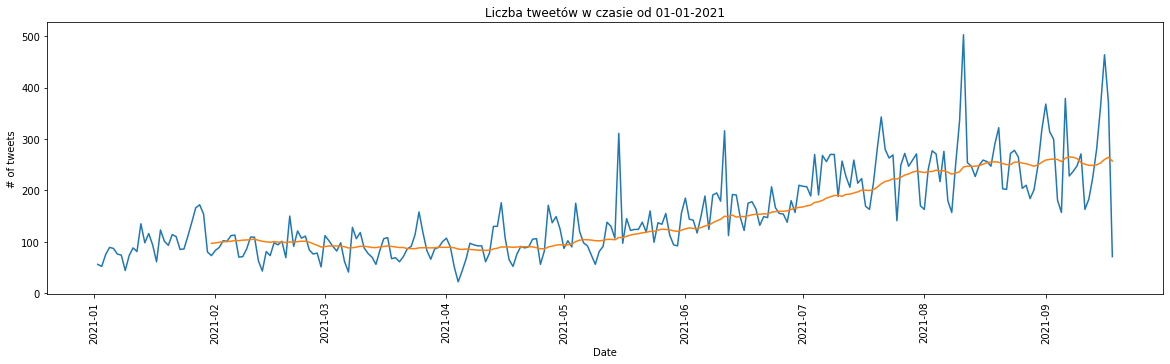

In [ ]:
new_tweets = data[data['date'] > pd.to_datetime('2021-01-01')].groupby('date')[['Tweet Id']].count()
new_tweets['SMA_30'] = new_tweets['Tweet Id'].rolling(window=30).mean()

plt.figure(figsize=(20,5))
plt.plot(new_tweets)
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('# of tweets')
plt.title('Liczba tweetów w czasie od 01-01-2021')
plt.show()

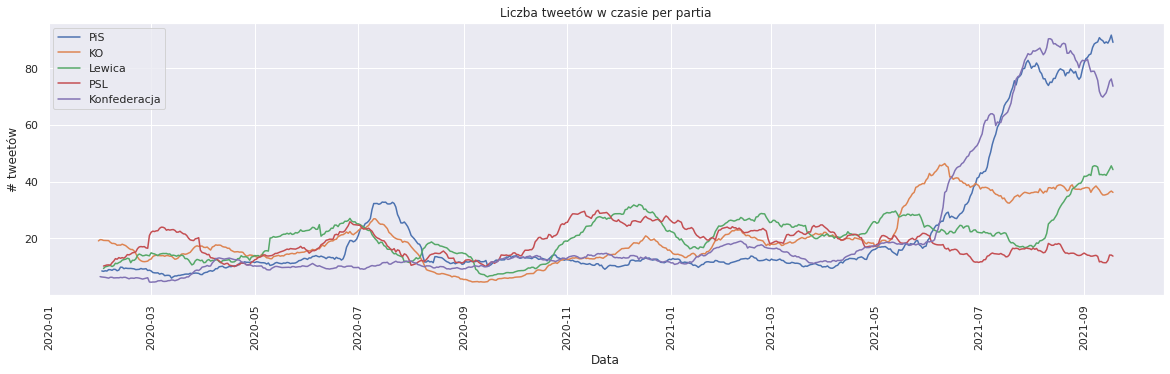

In [ ]:
plt.figure(figsize=(20,5))
for party in ['PiS', 'KO', 'Lewica', 'PSL', 'Konfederacja']:
  tweets_in_time_party = data[data['Party'] == party].groupby('date')[['Tweet Id']].count()
  tweets_in_time_party['SMA_30'] = tweets_in_time_party['Tweet Id'].rolling(window=30).mean()
  plt.plot(tweets_in_time_party['SMA_30'], label=party)
plt.xlabel('Data')
plt.xticks(rotation=90)
plt.ylabel('# tweetów')
plt.title('Liczba tweetów w czasie per partia')
plt.legend()
plt.show()

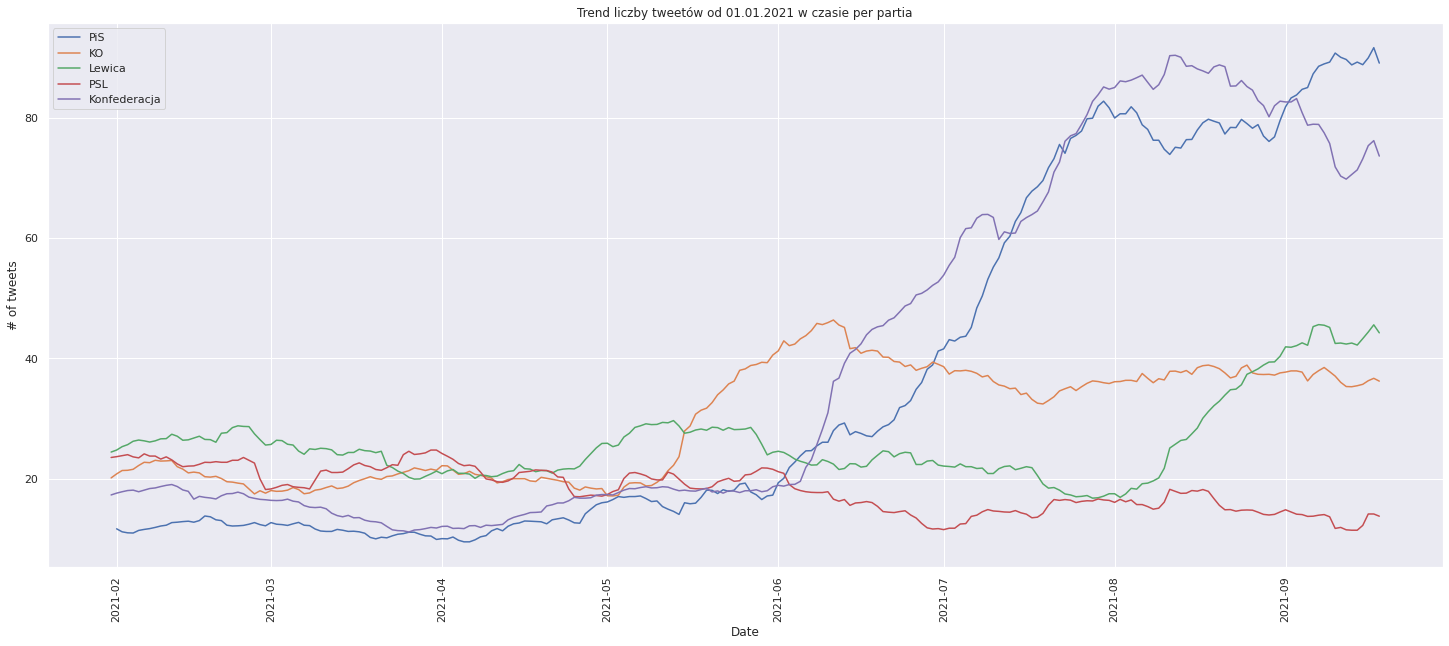

In [ ]:
new_tweets_1 = data[data['date'] > pd.to_datetime('2021-01-01')]

plt.figure(figsize=(25,10))
for party in ['PiS', 'KO', 'Lewica', 'PSL', 'Konfederacja']:
  tweets_in_time_party = new_tweets_1[new_tweets_1['Party'] == party].groupby('date')[['Tweet Id']].count()
  tweets_in_time_party['SMA_30'] = tweets_in_time_party['Tweet Id'].rolling(window=30).mean()
  plt.plot(tweets_in_time_party['SMA_30'], label=party)
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('# of tweets')
plt.title('Trend liczby tweetów od 01.01.2021 w czasie per partia')
plt.legend()
plt.show()

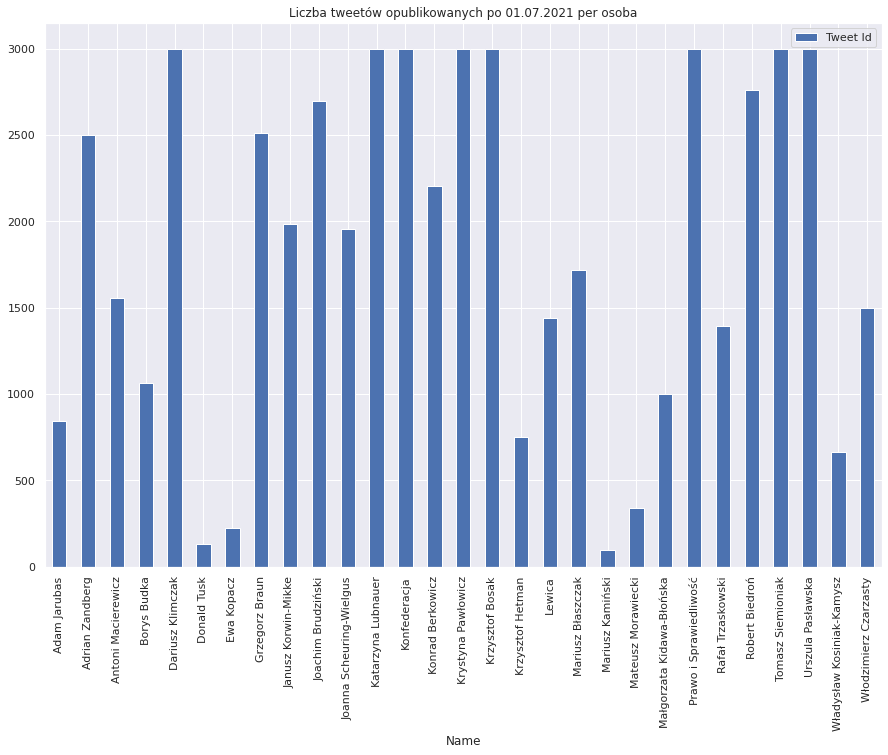

In [ ]:
tweets_per_politician = data[data['date'] > pd.to_datetime('2020-07-01')].groupby('Name')['Tweet Id'].count()

plt.figure(figsize=(15,10))
tweets_per_politician.plot.bar()
plt.title('Liczba tweetów opublikowanych po 01.07.2021 per osoba')
plt.legend()
plt.show()

In [ ]:
data.groupby('Name')['Tweet Id'].count()

Name
Adam Jarubas                 1250
Adrian Zandberg              3000
Antoni Macierewicz           2303
Borys Budka                  2592
Dariusz Klimczak             3000
Donald Tusk                   198
Ewa Kopacz                    504
Grzegorz Braun               2900
Janusz Korwin-Mikke          2552
Joachim Brudziński           3000
Joanna Scheuring-Wielgus     3000
Katarzyna Lubnauer           3000
Konfederacja                 3000
Konrad Berkowicz             2795
Krystyna Pawłowicz           3000
Krzysztof Bosak              3000
Krzysztof Hetman             1339
Lewica                       1440
Mariusz Błaszczak            2656
Mariusz Kamiński               96
Mateusz Morawiecki            463
Małgorzata Kidawa-Błońska    1391
Prawo i Sprawiedliwość       3000
Rafał Trzaskowski            2213
Robert Biedroń               2759
Tomasz Siemioniak            3000
Urszula Pasławska            3000
Władysław Kosiniak-Kamysz    2633
Włodzimierz Czarzasty        2870
Name: Twe

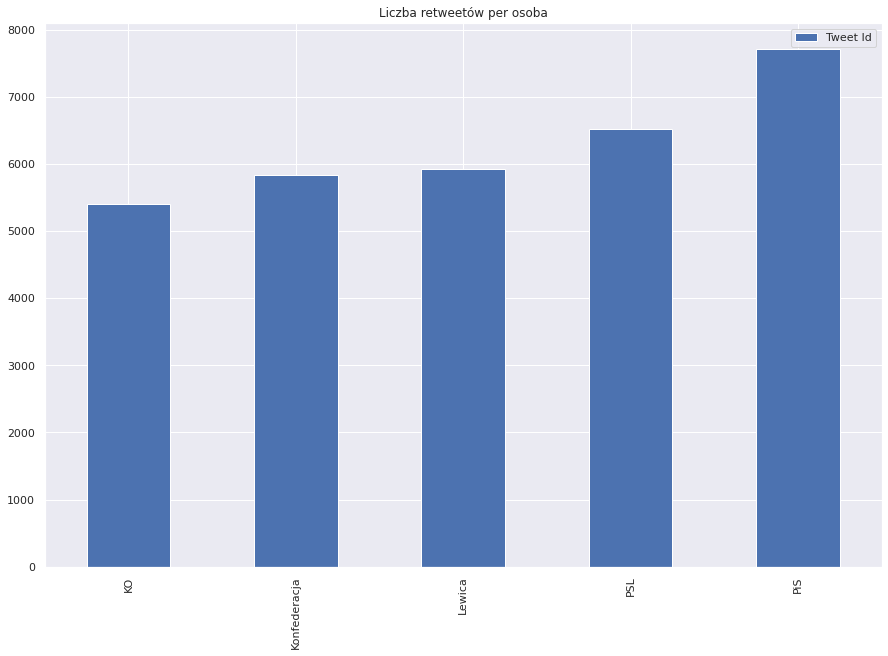

In [ ]:
retweets_per_politician = data[data['Is_retweet'] == True].groupby('Name')['Tweet Id'].count()

plt.figure(figsize=(15,10))
retweets_per_politician.plot.bar()
plt.xlabel('')
plt.title('Liczba retweetów per osoba')
plt.legend()
plt.show()

In [ ]:
retweets_per_party = data[data['Is_retweet'] == True].groupby('Party')['Tweet Id'].count()

In [ ]:
retweets_per_party

,Tweet Id
Party,
KO,5403
Konfederacja,5833
Lewica,5923
PSL,6522
PiS,7716


Text(0.5, 1.0, 'Liczba Tweetów per partia')

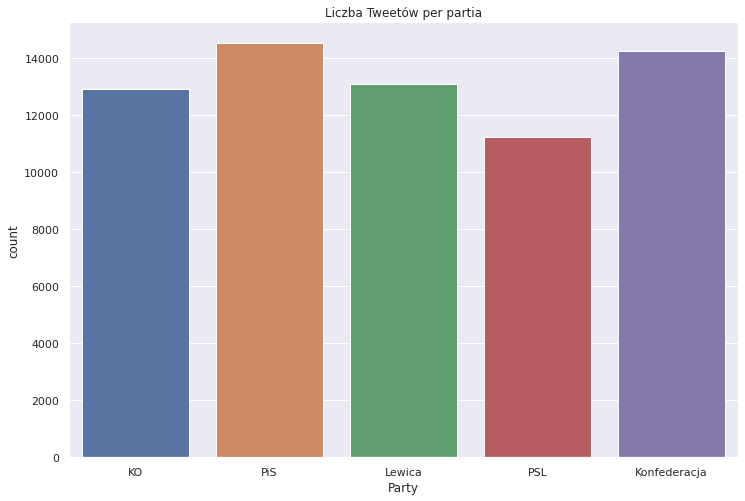

In [ ]:
sns.countplot(x='Party', data=data).set_title('Liczba Tweetów per partia')

Text(0.5, 1.0, 'Liczba Retweetów per partia')

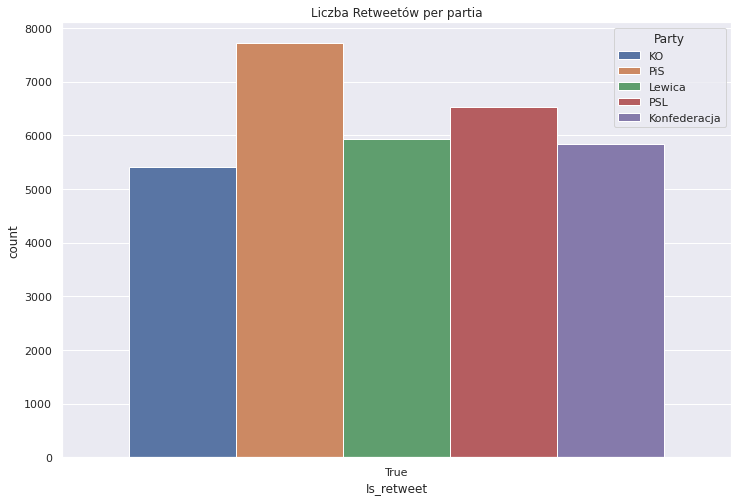

In [ ]:
sns.countplot(x='Is_retweet', data=data[data['Is_retweet'] == True], hue='Party').set_title('Liczba Retweetów per partia')

Text(0.5, 1.0, 'Liczba odpowiedzi per partia')

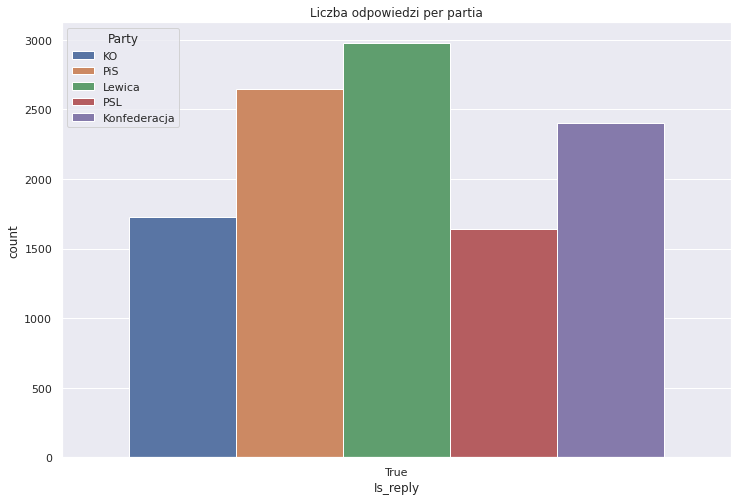

In [ ]:
sns.countplot(x='Is_reply', data=data[data['Is_reply'] == True], hue='Party').set_title('Liczba odpowiedzi per partia')

Text(0.5, 1.0, 'Aktywność partii w ciągu dnia')

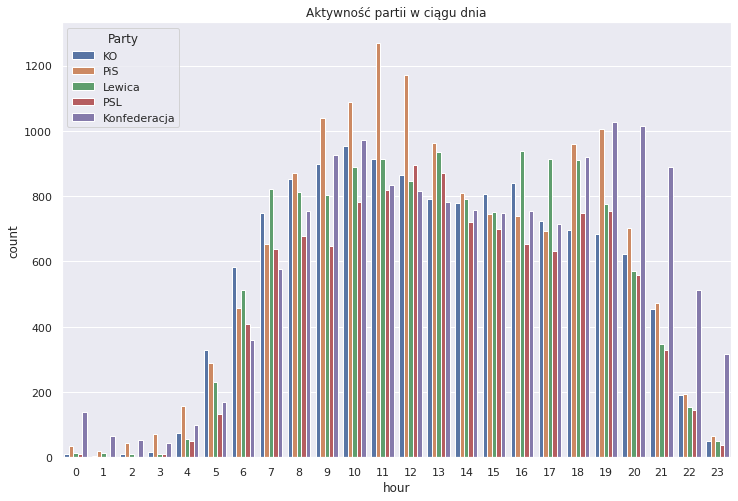

In [ ]:
sns.countplot(x='hour', data=data, hue='Party').set_title('Aktywność partii w ciągu dnia')

Text(0.5, 1.0, 'Aktywność partii w ciągu tygodnia')

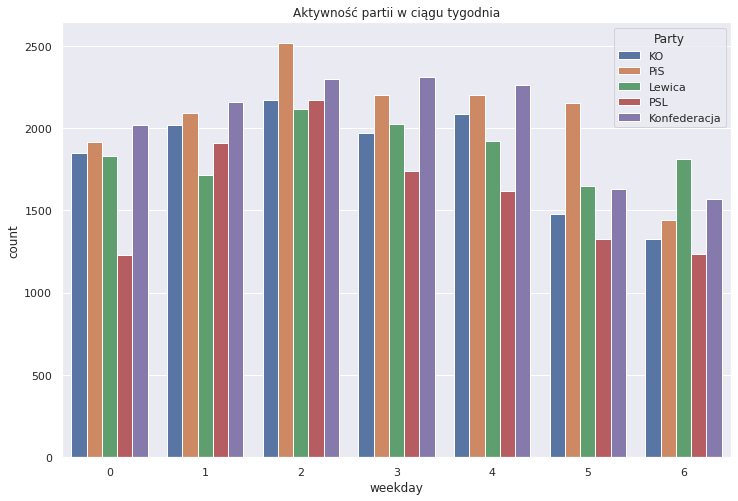

In [ ]:
sns.countplot(x='weekday', data=data, hue='Party').set_title('Aktywność partii w ciągu tygodnia')

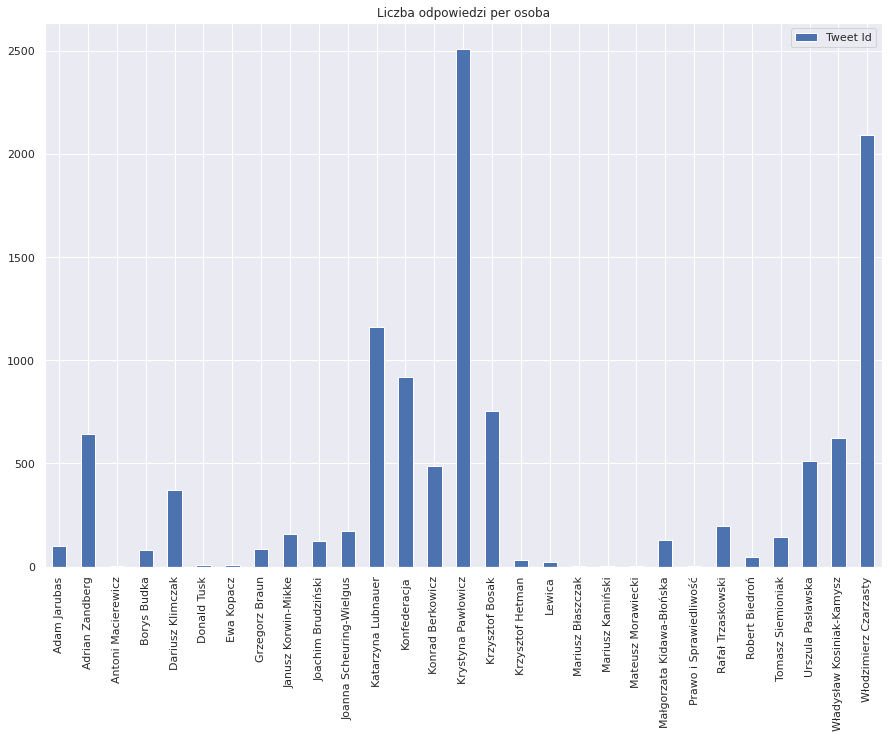

In [ ]:
replies_per_politician = data[data['Is_reply'] == True].groupby('Name')['Tweet Id'].count()

plt.figure(figsize=(15,10))
replies_per_politician.plot.bar()
plt.xlabel('')
plt.title('Liczba odpowiedzi per osoba')
plt.legend()
plt.show()

In [ ]:
retweets_in_time

date
2021-01-02    1534
2021-01-03     378
2021-01-04    1057
2021-01-05    1388
2021-01-06    1955
              ... 
2021-09-14    3923
2021-09-15    5706
2021-09-16    4447
2021-09-17    3377
2021-09-18     438
Name: Retweet_Count, Length: 260, dtype: int64

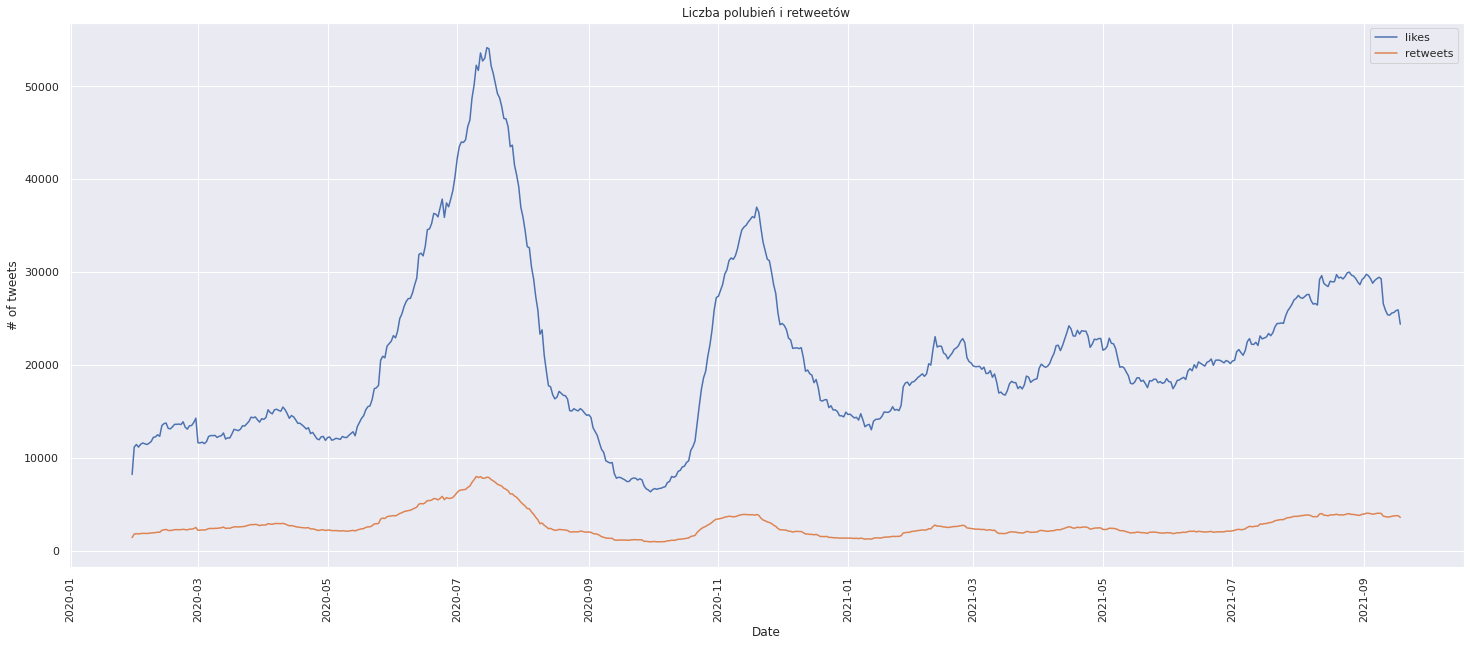

In [ ]:
likes_in_time = data.groupby('date')['Favorite_Count'].sum()
likes_in_time = pd.DataFrame(likes_in_time)
likes_in_time['SMA_30'] = likes_in_time['Favorite_Count'].rolling(window=30).mean()

#dla liczby retweetow trzeba wziąć tylko oryginalne wypowiedzi:
original_tweets = data[data['Is_retweet'] == False]
retweets_in_time = original_tweets.groupby('date')['Retweet_Count'].sum()
retweets_in_time = pd.DataFrame(retweets_in_time)
retweets_in_time['SMA_30'] = retweets_in_time['Retweet_Count'].rolling(window=30).mean()

plt.figure(figsize=(25,10))
plt.plot(likes_in_time['SMA_30'], label='likes')
plt.plot(retweets_in_time['SMA_30'], label='retweets')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('# of tweets')
plt.title('Liczba polubień i retweetów')
plt.legend()
plt.show()

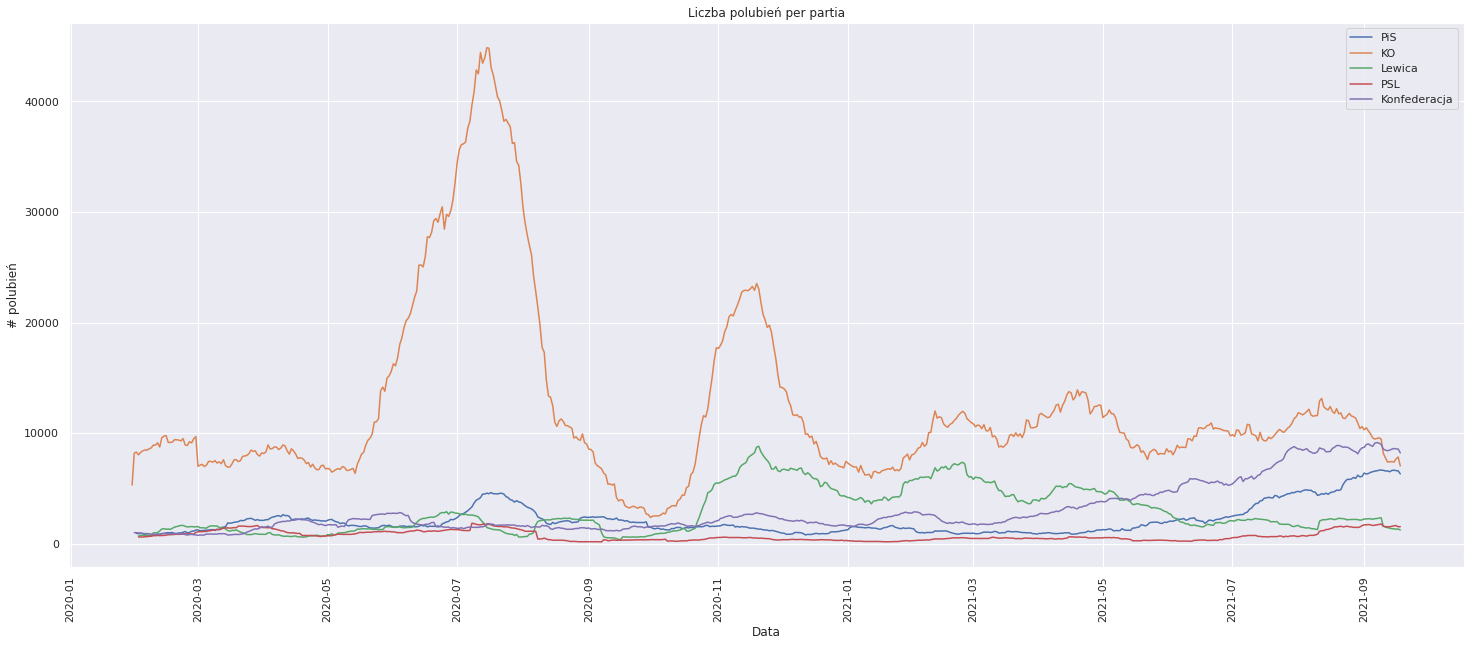

In [ ]:
plt.figure(figsize=(25,10))
for party in ['PiS', 'KO', 'Lewica', 'PSL', 'Konfederacja']:
  likes_in_time_party = data[data['Party'] == party].groupby('date')['Favorite_Count'].sum()
  likes_in_time_party = pd.DataFrame(likes_in_time_party)
  likes_in_time_party['SMA_30'] = likes_in_time_party['Favorite_Count'].rolling(window=30).mean()
  plt.plot(likes_in_time_party['SMA_30'], label=party)
plt.xlabel('Data')
plt.xticks(rotation=90)
plt.ylabel('# polubień')
plt.title('Liczba polubień per partia')
plt.legend()
plt.show()

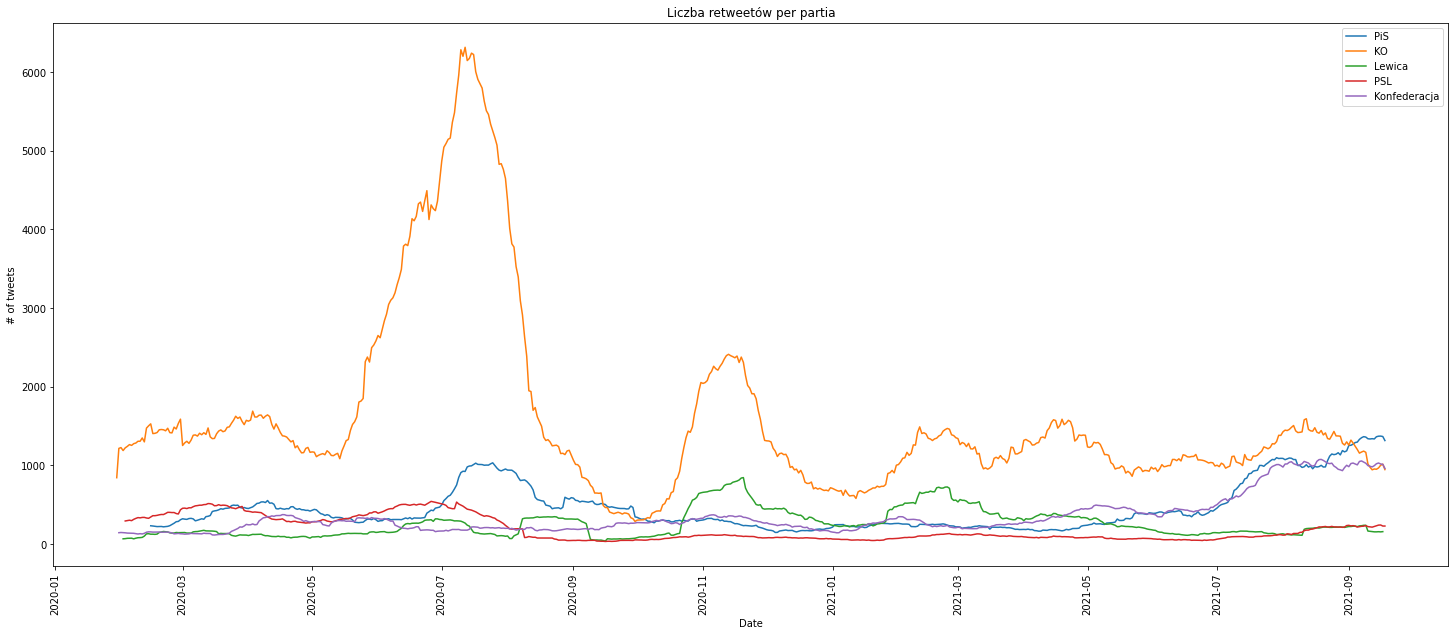

In [ ]:
plt.figure(figsize=(25,10))
for party in ['PiS', 'KO', 'Lewica', 'PSL', 'Konfederacja']:
  retweets_in_time_party = original_tweets[original_tweets['Party'] == party].groupby('date')['Retweet_Count'].sum()
  retweets_in_time_party = pd.DataFrame(retweets_in_time_party)
  retweets_in_time_party['SMA_30'] = retweets_in_time_party['Retweet_Count'].rolling(window=30).mean()
  plt.plot(retweets_in_time_party['SMA_30'], label=party)
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('# of tweets')
plt.title('Liczba retweetów per partia')
plt.legend()
plt.show()

In [ ]:
data = data.astype({'time' : 'str'})

In [ ]:
data['hour'] = data['time'].str[:2]

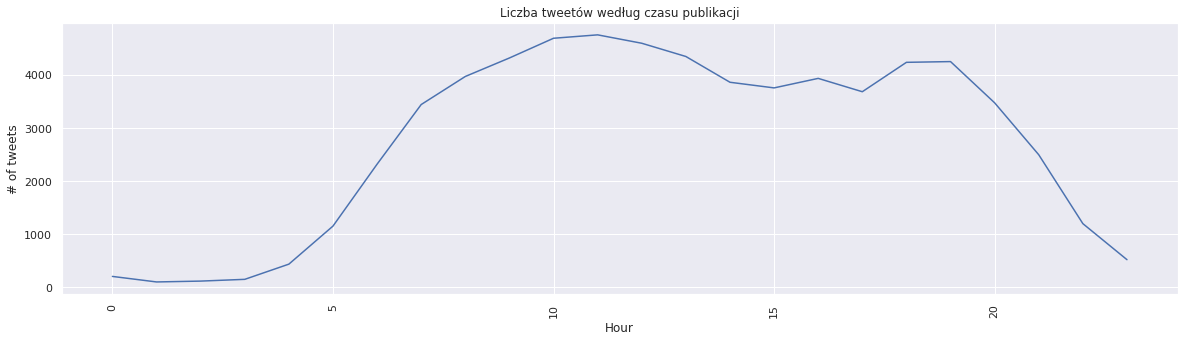

In [ ]:
tweets_in_hours = data.groupby('hour')[['Tweet Id']].count()

plt.figure(figsize=(20,5))
plt.plot(tweets_in_hours)
plt.xlabel('Hour')
plt.xticks(rotation=90)
plt.ylabel('# of tweets')
plt.title('Liczba tweetów według czasu publikacji')
plt.show()

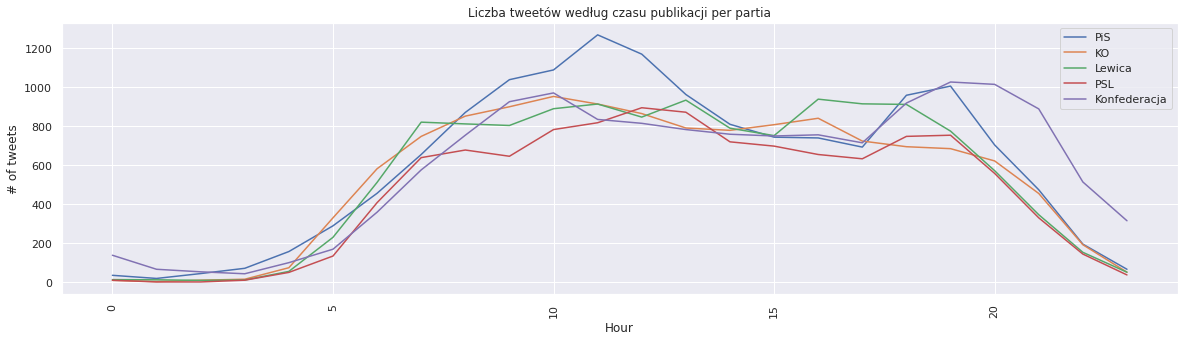

In [ ]:
plt.figure(figsize=(20,5))
for party in ['PiS', 'KO', 'Lewica', 'PSL', 'Konfederacja']:
  tweets_in_hours_party = data[data['Party'] == party].groupby('hour')[['Tweet Id']].count()
  plt.plot(tweets_in_hours_party, label=party)
plt.xlabel('Hour')
plt.xticks(rotation=90)
plt.ylabel('# of tweets')
plt.title('Liczba tweetów według czasu publikacji per partia')
plt.legend()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

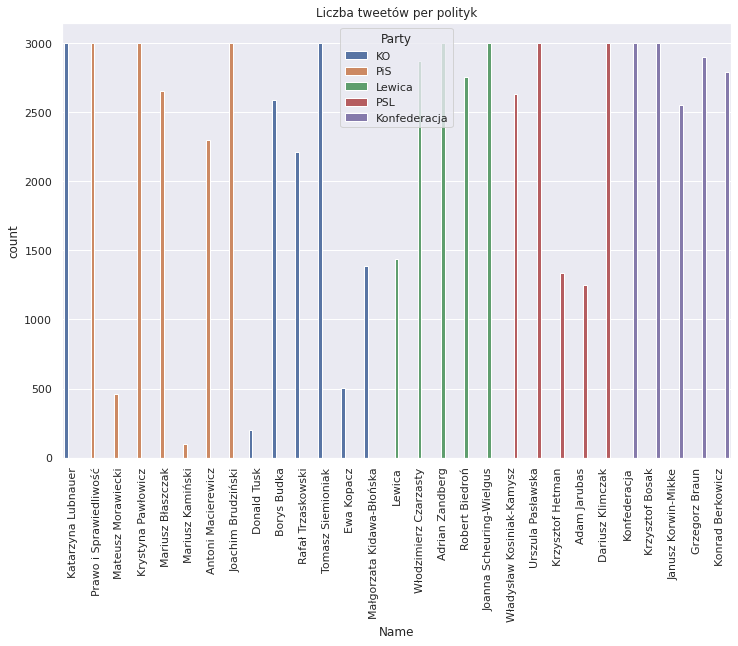

In [ ]:
sns.countplot(x='Name', data=data, hue='Party').set_title('Liczba tweetów per polityk')
plt.xticks(rotation=90)

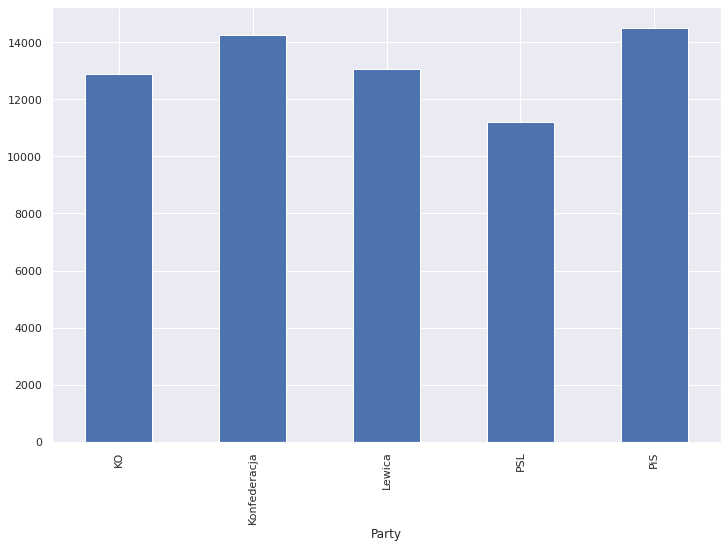

In [ ]:
partys = data.groupby('Party')['Tweet Id'].count()
partys.plot.bar()

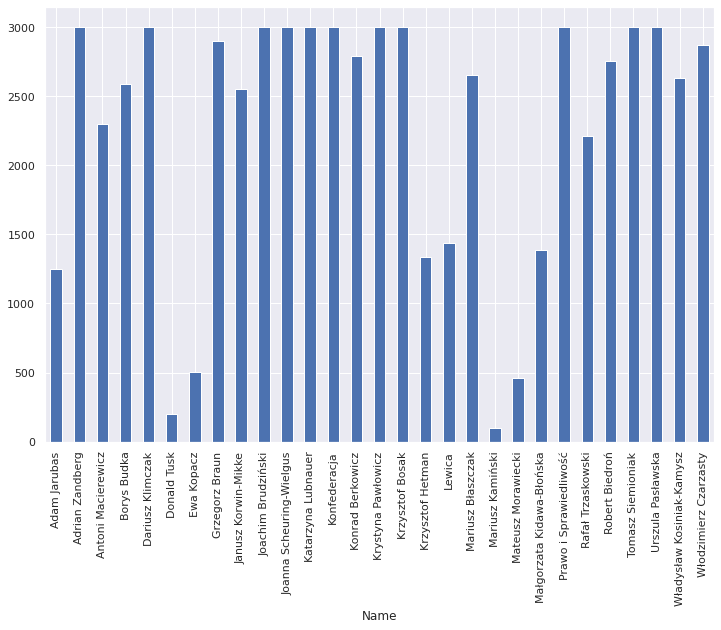

In [ ]:
autors = data.groupby('Name')['Tweet Id'].count()
autors.plot.bar()

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})

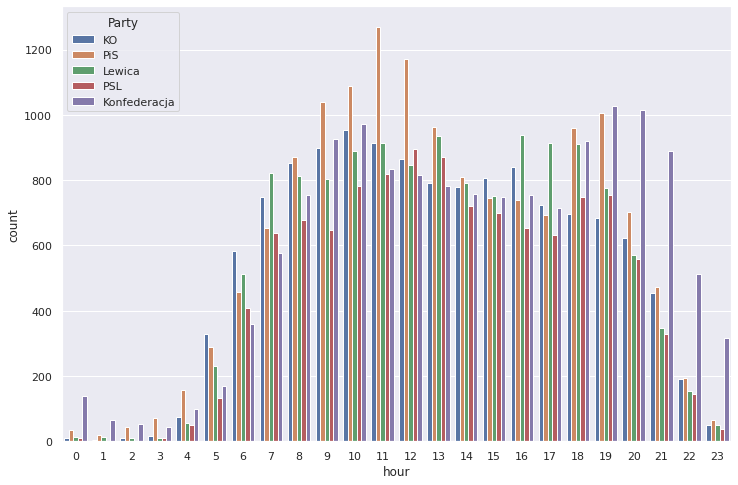

In [ ]:
sns.countplot(x='hour', data=data, hue='Party')

# Przygotowanie dla modelu

Lematyzacja

In [3]:
!pip install spacy==3

     |████████████████████████████████| 12.7 MB 219 kB/s 
     |████████████████████████████████| 456 kB 61.4 MB/s 
     |████████████████████████████████| 9.1 MB 55.0 MB/s 
     |████████████████████████████████| 623 kB 63.0 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [4]:
!python -m spacy download pl_core_news_sm

     |████████████████████████████████| 58.2 MB 52 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [5]:
import keras
import spacy
import numpy as np

from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

nlp = spacy.load('pl_core_news_sm')

In [6]:
import pandas as pd

In [7]:
#Załaduj dane z pliku, 
data = pd.read_csv('final_data.csv', index_col='Unnamed: 0', engine='python')
data = data.dropna() #tylko jeśli korzystamy z pliku zmergowanego z danymi Emila, bo tam były NaN w kolumnie tweet z tekstem tweeta
data = data[data['Lang_PL'] == True] #wybieramy wpisy po polsku
#data = data[data['Is_retweet'] == False] #wybieramy wpisy oryginalne
data = data.astype({'Datetime' : 'datetime64'})

In [ ]:
#data['year'] = pd.DatetimeIndex(data['Datetime']).year
#data['month'] = pd.DatetimeIndex(data['Datetime']).month
#ilosc = data.groupby(['year', 'month'])['Tweet Id'].count()
#dzielimy dane na treningowe i testowe po dacie 01.08.2021 >>> ilość tweetów w zbiorze 80% do 01.08.2021, 20% od 01.08.2021:
train_data = data[data['Datetime'] < pd.to_datetime('2021-08-01')]
test_data = data[data['Datetime'] >= pd.to_datetime('2021-08-01')]

print(test_data.info())
print(train_data.info())

Przygotowanie danych tekstowych i etykiet

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [10]:
label_enc = LabelEncoder()

train_labels_encoded = label_enc.fit_transform(train_data['Party'])
test_labels_encoded = label_enc.transform(test_data['Party'])

In [11]:
train_labels = to_categorical(train_labels_encoded)
test_labels = to_categorical(test_labels_encoded)

In [12]:
train_text_corpus = train_data['Text']
test_text_corpus = test_data['Text']

In [13]:
import string
from string import digits
import re

Usunięcie wspomnień linków, znaków przestankowych, cyfr, apostrofów, zamiana wielkich liter na małe 

In [14]:
# Remove @replies from source and target text
#regex = r'(@\w+\s)+'
#train_text_corpus = train_text_corpus.apply(lambda x: re.sub(regex, '', x))
#test_text_corpus = test_text_corpus.apply(lambda x: re.sub(regex, '', x))
#rezygnuje z tego, bo to może być znaczące, ludzie rozmawiają ze swoją banką, 
#a po drugie inaczej odnoszą się do przeciwników, jeśli to usunę, 
#to tak jakbym usunęła nie

# Remove URLS from source and target text
regex = r'https?:\/\/.*[\r\n]*'
train_text_corpus = train_text_corpus.apply(lambda x: re.sub(regex, '', x, flags=re.MULTILINE))
test_text_corpus = test_text_corpus.apply(lambda x: re.sub(regex, '', x, flags=re.MULTILINE))
# convert source and target text to Lowercase 
train_text_corpus = train_text_corpus.apply(lambda x: x.lower())
test_text_corpus = test_text_corpus.apply(lambda x: x.lower())
# Remove quotes from source and target text
train_text_corpus = train_text_corpus.apply(lambda x: re.sub("'", '', x))
test_text_corpus = test_text_corpus.apply(lambda x: re.sub("'", '', x))
# create a set of all special characters
special_characters= set(string.punctuation)
# Remove all the special characters
train_text_corpus = train_text_corpus.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
test_text_corpus = test_text_corpus.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
# Remove digits from source and target sentences
num_digits= str.maketrans('','', digits)
train_text_corpus = train_text_corpus.apply(lambda x: x.translate(num_digits))
test_text_corpus = test_text_corpus.apply(lambda x: x.translate(num_digits))

In [15]:
def lemmatize_text(text_corpus):
  lemmatized_text = []
  for tweet in tqdm(text_corpus):
    doc = nlp(tweet)
    doc_lemmatized = []
    for x in doc:
      if x.is_punct == False and x.is_stop == False:
        doc_lemmatized.append(x.lemma_)
    lemmatized_text.append(doc_lemmatized)
  return lemmatized_text

In [16]:
train_lemmatized = lemmatize_text(train_text_corpus)
test_lemmatized = lemmatize_text(test_text_corpus)

100%|██████████| 12232/12232 [02:26<00:00, 83.43it/s]


In [17]:
#sprawdzam średnią ilość słów
len_list = []
for e in train_lemmatized:
  len_list.append(len(e))
avg_len = sum(len_list) / len(len_list)
print(avg_len)

11.271882822277847


In [35]:
def tokenize(train_text, test_text, maxlen):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_text)
  word_index = tokenizer.word_index
  vocab_size = len(tokenizer.word_index)

  train_sequence = tokenizer.texts_to_sequences(train_text)
  test_sequence = tokenizer.texts_to_sequences(test_text)
  
  train_padded = pad_sequences(train_sequence, maxlen=maxlen)
  test_padded = pad_sequences(test_sequence, maxlen=maxlen)

  print('Input shape: ', train_padded.shape, test_padded.shape)
  print('Vocabulary size: ', vocab_size)
  return vocab_size, word_index, train_padded, test_padded

In [36]:
max_lenght = 20
vocab_size, word_index, train_padded, test_padded = tokenize(train_text=train_lemmatized,
                                                 test_text=test_lemmatized,
                                                 maxlen=max_lenght)

Input shape:  (51136, 20) (12232, 20)
Vocabulary size:  53762


# Jakiś model...

In [41]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, GRU, Dense, Flatten, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [65]:
!wget http://dsmodels.nlp.ipipan.waw.pl/w2v.html/nkjp-lemmas-all-100-cbow-hs.txt.gz
!wget http://dsmodels.nlp.ipipan.waw.pl/w2v.html/nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz

--2021-09-20 18:32:18--  http://dsmodels.nlp.ipipan.waw.pl/w2v.html/nkjp-lemmas-all-100-cbow-hs.txt.gz
Resolving dsmodels.nlp.ipipan.waw.pl (dsmodels.nlp.ipipan.waw.pl)... 213.135.36.94
Connecting to dsmodels.nlp.ipipan.waw.pl (dsmodels.nlp.ipipan.waw.pl)|213.135.36.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51928 (51K) [text/html]
Saving to: ‘nkjp-lemmas-all-100-cbow-hs.txt.gz.1’

nkjp-lemmas-all-100 100%[===================>]  50.71K   223KB/s    in 0.2s    

2021-09-20 18:32:19 (223 KB/s) - ‘nkjp-lemmas-all-100-cbow-hs.txt.gz.1’ saved [51928/51928]

--2021-09-20 18:32:19--  http://dsmodels.nlp.ipipan.waw.pl/w2v.html/nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz
Resolving dsmodels.nlp.ipipan.waw.pl (dsmodels.nlp.ipipan.waw.pl)... 213.135.36.94
Connecting to dsmodels.nlp.ipipan.waw.pl (dsmodels.nlp.ipipan.waw.pl)|213.135.36.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51928 (51K) [text/html]
Saving to: ‘nkjp+wiki-lemmas-all-100

In [72]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [76]:
embeddings_index = {}

# f = open('nkjp+wiki-lemmas-all-100-cbow-hs.txt')
f = open(r'/content/drive/MyDrive/nkjp+wiki-lemmas-all-100-cbow-hs.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Znaleziono %s wektorów słów.' % len(embeddings_index))

Znaleziono 1549323 wektorów słów.


In [77]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # Słowa nieznalezione w osadzanym indeksie zostaną zastąpione zerami.
            embedding_matrix[i] = embedding_vector

In [82]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_lenght))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(GRU(32, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(5, activation="softmax"))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 100)           5376300   
_________________________________________________________________
gru_10 (GRU)                 (None, 20, 64)            31872     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
gru_11 (GRU)                 (None, 20, 32)            9408      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

In [83]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, 
                    epochs=10, batch_size=32, 
                    validation_data=(test_padded, test_labels),
                    callbacks=[EarlyStopping(monitor='val_loss', 
                                              min_delta=0,
                                              patience=2,
                                              verbose=0, 
                                              mode='auto')])

model.save_weights('pre_trained_nkjp+wiki_model.h5')

Epoch 1/10
1598/1598 [==============================] - 39s 22ms/step - loss: 1.3233 - accuracy: 0.4437 - val_loss: 1.4344 - val_accuracy: 0.3974
Epoch 2/10
1598/1598 [==============================] - 39s 25ms/step - loss: 1.1866 - accuracy: 0.5189 - val_loss: 1.3608 - val_accuracy: 0.4344
Epoch 3/10
1598/1598 [==============================] - 38s 24ms/step - loss: 1.1272 - accuracy: 0.5471 - val_loss: 1.2970 - val_accuracy: 0.4534
Epoch 4/10
1598/1598 [==============================] - 41s 25ms/step - loss: 1.0785 - accuracy: 0.5689 - val_loss: 1.3588 - val_accuracy: 0.4428
Epoch 5/10
1598/1598 [==============================] - 40s 25ms/step - loss: 1.0406 - accuracy: 0.5865 - val_loss: 1.2936 - val_accuracy: 0.4715
Epoch 6/10
1598/1598 [==============================] - 41s 26ms/step - loss: 1.0072 - accuracy: 0.6049 - val_loss: 1.3465 - val_accuracy: 0.4548
Epoch 7/10
1598/1598 [==============================] - 38s 24ms/step - loss: 0.9767 - accuracy: 0.6186 - val_loss: 1.3269 -

In [84]:
y_pred = model.predict(test_padded)
print(classification_report(test_labels_encoded, y_pred.argmax(axis=1), target_names=label_enc.classes_))

              precision    recall  f1-score   support

          KO       0.28      0.38      0.32      1722
Konfederacja       0.63      0.47      0.54      3720
      Lewica       0.30      0.38      0.33      2078
         PSL       0.21      0.49      0.30       724
         PiS       0.77      0.55      0.64      3988

    accuracy                           0.47     12232
   macro avg       0.44      0.45      0.43     12232
weighted avg       0.55      0.47      0.49     12232



# Zapisanie modelu do pliku

In [85]:
from keras.models import load_model

In [86]:
model.save('test_model_for_dash.h5')

In [87]:
#model.save_weights('/content/drive/MyDrive/pre_trained_nkjp+wiki_model.h5')
#model.save('/content/drive/MyDrive/test_model_for_dash.h5')

Wczytanie modelu z pliku

In [ ]:
loaded_model = load_model('test_model_for_dash.h5')